In [ ]:
import os
import sys
import pandas as pd
import argparse
import warnings
from utils import *
from torch import nn
import copy
from tqdm import tqdm
import random 
from data_loader import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import numpy as np
from http import HTTPStatus
import dashscope
from xgboost import XGBRegressor
from dashscope import Generation
import json
# import openai
from deepseek import DeepSeekClient
import os
from train import *
from model import GurobiPowerScheduler
import pickle
from openai import OpenAI
warnings.filterwarnings("ignore")
#set deepseek and openai API keys


dashscope.api_key = 'YOUR KEY'
DEEPSEEK_API_KEY = 'YOUR KEY'
OPENAI_API_KEY = 'YOUR KEY'
LLAMA_API_KEY= 'YOUR KEY'

In [29]:
parser_train = argparse.ArgumentParser()
parser_train.add_argument('--seq_len', type=int, default=24*7)
parser_train.add_argument('--pred_len', type=int, default=24)
parser_train.add_argument('--label_len', type=int, default=0)
parser_train.add_argument('--train_length', type=int, default=17376)
parser_train.add_argument('--target', type=str, default='target')
parser_train.add_argument('--scale', type=bool, default=True)
parser_train.add_argument('--inverse', type=bool, default=True)
parser_train.add_argument('--num_epochs', type=int, default=1000)
parser_train.add_argument('--mode', type=str, default='seq2seq')
parser_train.add_argument('--quantiles', type=list, default=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95])
parser_train.add_argument('--lr', type=float, default=1e-3)
parser_train.add_argument('--patience', type=int, default=5)
parser_train.add_argument('--hidden_layers', type=list, default=[128,128,128])
parser_train.add_argument('--e2e_num_epochs', type=int, default=5)
parser_train.add_argument('--e2e_ft_lr', type=float, default=1e-6)
parser_train.add_argument('--e2e_lr', type=float, default=1e-7)#1e-7
parser_train.add_argument('--ft_lr', type=float, default=1e-4)
parser_train.add_argument('--batch_size', type=int, default=16)
parser_train.add_argument('--device', type=str, default='cuda:0' if torch.cuda.is_available() else 'cpu')
parser_train.add_argument('--epsion_p', type=float, default=1e1)
parser_train.add_argument('--epsion_l', type=float, default=1e1)
parser_train.add_argument('--metric_list', type=list, default=['pinball_loss','winkler_score_0.1','MAE','RMSE'])


parser_train.add_argument('--N_g', type=int, default=3)
parser_train.add_argument('--T', type=int, default=24)
parser_train.add_argument('--N', type=int, default=25)
parser_train.add_argument('--x_max', type=int, default=[1500,1800,2000])
parser_train.add_argument('--x_min', type=int, default=[0,0,0])
parser_train.add_argument('--z_pos_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_neg_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_pos_min', type=int, default=0)
parser_train.add_argument('--z_neg_min', type=int, default=0)
parser_train.add_argument('--r_neg', type=int, default=[800,800,500])
parser_train.add_argument('--r_pos', type=int, default=[800,800,500])
parser_train.add_argument('--alpha', type=list, default=[0.03 for i in range(24)]+[0.028 for i in range(24)]+[0.032 for i in range(24)])
parser_train.add_argument('--alpha_pos', type=list, default=[0.02 for i in range(24)]+[0.018 for i in range(24)]+[0.022 for i in range(24)])
parser_train.add_argument('--alpha_neg', type=list, default=[0.01 for i in range(24)]+[0.009 for i in range(24)]+[0.011 for i in range(24)])

parser_train.add_argument('--rho_z_pos', type=list, default=[0.05 for i in range(24)]+[0.045 for i in range(24)]+[0.055 for i in range(24)])
parser_train.add_argument('--rho_z_neg', type=list, default=[0.01 for i in range(24)]+[0.008 for i in range(24)]+[0.012 for i in range(24)])

parser_train.add_argument('--rho_r_pos', type=list, default=[0.1 for i in range(24)])
parser_train.add_argument('--rho_r_neg', type=list, default=[0.05 for i in range(24)])

parser_train.add_argument('--price_ratio_large', type=float, default=2.5)
parser_train.add_argument('--price_ratio_small', type=float, default=0.8)
parser_train.add_argument('--flag_dynamic_price', type=bool, default=False)
parser_train.add_argument('--flag_dynamic_mode', type=int, default=0)
parser_train.add_argument('--upper_quantiles', type=float, default=0.95)
parser_train.add_argument('--lower_quantiles', type=float, default=0.05)
parser_train.add_argument('--epsion', type=float, default=1)
parser_train.add_argument('--LLM_type', type=str, default='Qwen') #'euclidean' 'manhattan'
args = parser_train.parse_args(args=[])

In [30]:
train_load_data,train_load_loader=get_load_data(args,flag='train')
val_load_data,val_load_loader=get_load_data(args,flag='val')
test_load_data,test_load_loader=get_load_data(args,flag='test')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

X_test=train_load_data.inverse_transform_X(test_load_data.X)
X_train=train_load_data.inverse_transform_X(train_load_data.X)
X_val=train_load_data.inverse_transform_X(val_load_data.X)

(26113, 219)
(26113, 219)
(26113, 219)


In [31]:
from utils import *
combined_train_data,combined_train_loader,combined_val_data,combined_val_loader,combined_test_data,combined_test_loader,combined_fine_tune_data,combined_fine_tune_loader = obtain_price(args,train_load_data,val_load_data,test_load_data)
data_iter = iter(combined_test_loader)
input_load_test, labels_load_test, alpha_test, alpha_z_test, rho_z_test, rho_r_test = next(data_iter)

alpha_sample=alpha_test[0,:].detach().cpu().numpy()
alpha_z_sample=alpha_z_test[0,:].detach().cpu().numpy()
rho_z_sample=rho_z_test[0,:].detach().cpu().numpy()
rho_r_sample=rho_r_test[0,:].detach().cpu().numpy()

optimization_module = GurobiPowerScheduler(args, alpha_sample, alpha_z_sample, rho_z_sample, rho_r_sample)

x_max_list (72,)
r_pos_list (69,)
r_neg_list (69,)
[1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500.
 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500.
 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800.
 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.]


In [32]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
input_size=train_load_data.X.shape[-1]

set_seed(42)
output_size=24
#objective='reg:squarederror',
model_xgb = MultiOutputRegressor(XGBRegressor(
    max_depth=3,           # 降低树深度（默认6，建议3-5）
    min_child_weight=5,    # 叶子节点最小样本权重和（防止过细分裂）
    gamma=0.01,            # 分裂最小损失下降（越大越保守）
    reg_lambda=5,        # L2正则化（默认1，可增大）
    n_estimators=50
)
)
model_xgb.fit(train_load_data.X, train_load_data.y)

test_pred_nor=model_xgb.predict(test_load_data.X)
test_pred= train_load_data.inverse_transform(test_pred_nor)
test_actual_nor=test_load_data.y#.reshape(-1,1)
actual_load_test = train_load_data.inverse_transform(test_actual_nor)

cost_list_test=[]
cost_list_ideal=[]
for i in range(len(test_pred)):
    forecast=test_pred[i]
    actual=actual_load_test[i]
    _,_,costs_org=optimization_module.forward(forecast, actual)
    _,_,costs_ideal=optimization_module.forward(actual, actual)
    cost_list_test.append(costs_org)
    cost_list_ideal.append(costs_ideal)
    

print(MAE(test_pred,actual_load_test),RMSE(test_pred,actual_load_test),MAPE(test_pred,actual_load_test))

142.49279504534843 181.69046965491634 0.040117127187335976


In [33]:
val_pred_nor=model_xgb.predict(val_load_data.X)
val_pred = train_load_data.inverse_transform(val_pred_nor)
val_actual_nor=val_load_data.y#.reshape(-1,1)
actual_load_val = train_load_data.inverse_transform(val_actual_nor)

cost_list_val=[]
cost_list_val_ideal=[]
for i in range(len(val_pred)):
    forecast=val_pred[i]
    actual=actual_load_val[i]
    _,_,costs_org=optimization_module.forward(forecast, actual)
    _,_,costs_ideal=optimization_module.forward(actual, actual)
    cost_list_val.append(costs_org)
    cost_list_val_ideal.append(costs_ideal)

print(MAE(val_pred,actual_load_val),RMSE(val_pred,actual_load_val),MAPE(val_pred,actual_load_val))


train_pred_nor=model_xgb.predict(train_load_data.X)
train_pred = train_load_data.inverse_transform(train_pred_nor)
train_actual_nor=train_load_data.y#.reshape(-1,1)
actual_load_train = train_load_data.inverse_transform(train_actual_nor)

cost_list_train=[]
cost_list_train_ideal=[]
for i in range(len(train_pred)):
    forecast=train_pred[i]
    actual=actual_load_train[i]
    _,_,costs_org=optimization_module.forward(forecast, actual)
    _,_,costs_ideal=optimization_module.forward(actual, actual)
    cost_list_train.append(costs_org)
    cost_list_train_ideal.append(costs_ideal)

print(MAE(train_pred,actual_load_train),RMSE(train_pred,actual_load_train),MAPE(train_pred,actual_load_train))

90.74887780336599 127.16092506028966 0.026737809014022222
59.09081991469172 79.51627355207512 0.01798264355907767


In [34]:
from E2E import E2E_test_ideal,E2E_test,E2E_train

In [35]:
from model import *
from E2E import *

In [36]:
cost_list_test_insert=[cost_list_test[i]-cost_list_ideal[i] for i in range(len(cost_list_test))]
actual_load_test_insert=test_actual_nor
forecasts_load_test_insert=test_pred_nor

cost_list_train_insert=[cost_list_train[i]-cost_list_train_ideal[i] for i in range(len(cost_list_train))]
actual_load_train_insert=train_actual_nor
forecasts_load_train_insert=train_pred_nor

cost_list_val_insert=[cost_list_val[i]-cost_list_val_ideal[i] for i in range(len(cost_list_val))]
actual_load_val_insert=val_actual_nor
forecasts_load_val_insert=val_pred_nor

db_train = CurveDictDB()
cur_id_start = max(db_train.data.keys(), default=0) + 1
for i, (cost, load, fine_tuned_load, actual_load) in enumerate(zip(cost_list_train_insert, forecasts_load_train_insert,forecasts_load_train_insert, actual_load_train_insert)):
    record = {
        'id': cur_id_start + i,
        'flag': 0,
        'prompt': '',
        'load': load,
        'fine_tuned_load': fine_tuned_load,
        'cost': cost,
        'actual_load': actual_load,
        'cost_reduction': 0, # 1代表成本比fine tune前低
    }
    db_train.insert(record)

db_val = CurveDictDB()
cur_id_start_val = max(db_val.data.keys(), default=0) + 1
for i, (cost, load, fine_tuned_load, actual_load) in enumerate(zip(cost_list_val_insert, forecasts_load_val_insert, forecasts_load_val_insert, actual_load_val_insert)):
    record = {
        'id': cur_id_start_val + i,
        'flag': 0,
        'prompt': '',
        'load': load,
        'fine_tuned_load': fine_tuned_load,
        'cost': cost,
        'actual_load': actual_load,
        'cost_reduction': 0,
    }
    db_val.insert(record)


In [37]:
def generate_prompt_sys(args,data):
    # Return English prompt
    prompt = (
        f"You are a power dispatch expert. There are {args.N_g} generating units:\n"
        f"Unit 1: {args.x_min}~{args.x_max} MW, "
        f"Unit 2: {args.x_min}~{args.x_max} MW, "
        f"Unit 3: {args.x_min}~{args.x_max} MW.\n"
        f"Unit 1 generation cost: {args.alpha[0:args.T]}*x RMB/kWh, "
        f"Unit 2 generation cost: {args.alpha[args.T:2*args.T]}*x RMB/kWh, "
        f"Unit 3 generation cost: {args.alpha[args.T*2:args.T*3]}*x RMB/kWh.\n"
        f"Unit 1 positive reserve limit: {args.rho_z_pos[0:args.T]} RMB/kWh, "
        f"Unit 1 negative reserve limit: {args.rho_z_neg[0:args.T]} RMB/kWh.\n"
        f"Unit 2 positive reserve limit: {args.rho_z_pos[args.T:2*args.T]} RMB/kWh, "
        f"Unit 2 negative reserve limit: {args.rho_z_neg[args.T:2*args.T]} RMB/kWh.\n"
        f"Unit 3 positive reserve limit: {args.rho_z_pos[args.T*2:args.T*3]} RMB/kWh, "
        f"Unit 3 negative reserve limit: {args.rho_z_neg[args.T*2:args.T*3]} RMB/kWh.\n"   
    #    f"Predicted load: {data['load']}\n"
    )
    
    return prompt



In [38]:
data_iter = iter(combined_test_loader)
input_load_test, labels_load_test, alpha_test, alpha_z_test, rho_z_test, rho_r_test = next(data_iter)

alpha_sample=alpha_test[0,:].detach().cpu().numpy()
alpha_z_sample=alpha_z_test[0,:].detach().cpu().numpy()
rho_z_sample=rho_z_test[0,:].detach().cpu().numpy()
rho_r_sample=rho_r_test[0,:].detach().cpu().numpy()

# alpha_sample_torch=torch.tensor(alpha_sample).unsqueeze(0).to(device)#.float()
# alpha_z_sample_torch=torch.tensor(alpha_z_sample).unsqueeze(0).to(device)#.float()
# rho_z_sample_torch=torch.tensor(rho_z_sample).unsqueeze(0).to(device)#.float()
# rho_r_sample_torch=torch.tensor(rho_r_sample).unsqueeze(0).to(device)#.float()

optimization_module = GurobiPowerScheduler(args, alpha_sample, alpha_z_sample, rho_z_sample, rho_r_sample)

x_max_list (72,)
r_pos_list (69,)
r_neg_list (69,)
[1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500.
 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500.
 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800.
 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.]


In [39]:


output_require_prompt = """Please learn from the few-shot record and derived a combined strategy to adjust the original load curve.
    You can only change several time points, and each point can only be changed within ±10% of the original value.
    Output a Python function named "adjustment_strategy" that implements the optimization strategy. The function should take the original load curve as input and return a list of 24 delta values (changes to apply).

    Requirements:
    1. Define a function: def adjustment_strategy(original_load: list) -> list:
    2. The function must return a list of 24 numbers (deltas)
    3. Use only basic Python operations (no external libraries)
    4. Include comments explaining your strategy
    5. Example:
        def adjustment_strategy(original_load):
            deltas = []
            for i, load_val in enumerate(original_load):
                if 8 <= i < 18:
                    deltas.append(load_val * 0.05) 
                if 20 <= i <22:
                    deltas.append(-load_val * 0.03) 
            return deltas
    """

### main

In [40]:
def few_shot_prompt_generate(args, similar_days, max_strategies=10, max_attempts=5,failure_strategy=None):  
    """  
    Generate few-shot prompts for small-scale adjustment strategies  
    Each adjustment modifies no more than 5 time points, gradually building a strategy library  
      
    Parameters:  
        args: Model parameters  
        db: Database connection object  
        similar_days: List of similar day data  
        max_strategies: Maximum number of valid strategies  
        max_attempts: Maximum number of attempts  
          
    Returns:  
        tuple: (Strategy history string, List of valid strategies)  
    """  
    # Get average load of similar days
    similar_day_load_nor = np.mean([day['load'] for day in similar_days], axis=0)  
    similar_day_actual_nor = np.mean([day['actual_load'] for day in similar_days], axis=0)  
      
    # Calculate original cost  
    similar_day_load_numpy = train_load_data.scaler_y.inverse_transform(np.array(similar_day_load_nor).reshape(1,-1))[0]  
    similar_day_actual_load_numpy = train_load_data.scaler_y.inverse_transform(np.array(similar_day_actual_nor).reshape(1,-1))[0]  
    _, _, original_cost = optimization_module.forward(similar_day_load_numpy, similar_day_actual_load_numpy)  
    original_cost = original_cost.item()  
      
    # Strategy generation prompt template  
    sim_data = {"load": similar_day_load_nor}  
    system_prompt = generate_prompt_sys(args, sim_data)  
    higher_flag = "higher" if sum(np.array(similar_day_load_nor) - np.array(similar_day_actual_nor)) > 0 else "lower"  
    reduce_flag = "reduce" if higher_flag == "higher" else "increase"  
    system_prompt += f"""\n The maximum load occurs at {int(np.argmax(similar_day_load_nor))} hour, and the minimum load occurs at {int(np.argmin(similar_day_load_nor))} hour.\n\n"""  
    system_prompt += f"""  
    You have two approaches to reduce cost:  

    1. Compare the actual value and forecast of the similar day, try to learn some error reduction strategies. In this case, the similar day forecast is {higher_flag} than actual, so you can try to {reduce_flag} the load in some hours to reduce cost.  
    2. Compare the future positive and negative reserve prices.  
    - If the positive reserve price is much higher than the negative reserve price, you should schedule more generation in the day-ahead market.  
    - If the negative reserve price is higher, schedule less generation to reduce potential costs.  
    """  

    if failure_strategy==None:
        pass
    else:
        system_prompt+='Here is failed strategy:\n'+failure_strategy


    output_require_prompt = f"""  
    You are an expert in electricity load curve optimization. Your task is to generate Python functions that implement small-scale optimization strategies for daily electricity load curves.  

    Requirements:  
    1. Generate exactly 10 distinct Python functions named "strategy_1", "strategy_2", "strategy_3", "strategy_4", "strategy_5", "strategy_6", "strategy_7", "strategy_8", "strategy_9", and "strategy_10".  
    2. The strategy should focus on a *different* part of the load curve, avoiding concentrating all changes in same time intervals.  
    2. Each function must:  
       - Take a single argument: the original load curve (list of 24 hourly values)  
       - Return a list of 24 numbers (deltas) representing adjustments to each hour  
    3. Each strategy must:  
       - Adjust no more than 5 time points (hours)  
       - Target adjacent hours (e.g., 7pm to 9pm)  
       - Keep adjustments within ±15% of the original value at each hour  
       - Try to be distinct from other strategies  
    4. Use only basic Python operations (no external libraries)  
    5. Include comments explaining:  
       - Which specific hours are targeted  
       - Why this strategy might reduce electricity costs  
    6. Example strategies:  

    Example 1: Reduce evening peak  
    def strategy_1(original_load):  
        # Focus: Reduce peak at 18:00 and 19:00 only  
        deltas = [0] * 24  
        # Only adjust hours 18 and 19  
        deltas[18] = -original_load[18] * 0.02  # Reduce by 2%  
        deltas[19] = -original_load[19] * 0.02  # Reduce by 2%  
        return deltas  

    Example 2: Shift load from afternoon to late afternoon  
    def strategy_2(original_load):  
        # Focus: Shift load from 14:00 to 15:00  
        deltas = [0] * 24  
        # Only adjust hours 14 and 15  
        deltas[14] = original_load[14] * 0.015  # Reduce at 14:00  
        deltas[15] = original_load[14] * 0.015   # Increase at 15:00  
        return deltas  

    Example 3: Increase off-peak consumption  
    def strategy_3(original_load):  
        # Focus: Slightly increase off-peak at 2:00 and 3:00  
        deltas = [0] * 24  
        # Only adjust hours 2 and 3  
        deltas[2] = original_load[2] * 0.03  # Increase by 3%  
        deltas[3] = original_load[3] * 0.03  # Increase by 3%  
        return deltas  

    Example 4: Flatten morning peak  
    def strategy_4(original_load):  
        # Focus: Reduce morning peak at 8:00 and shift to 9:00  
        deltas = [0] * 24  
        # Only adjust hours 8 and 9  
        deltas[8] = -original_load[8] * 0.05  # Reduce at 8:00  
        deltas[9] = original_load[8] * 0.05   # Increase at 9:00  
        return deltas  

    Example 5: Smooth transition between peak and off-peak  
    def strategy_5(original_load):  
        # Focus: Smooth transition from evening to night (20:00-21:00)  
        deltas = [0] * 24  
        # Only adjust hours 20 and 21  
        deltas[20] = -original_load[20] * 0.02  # Reduce at 20:00  
        deltas[21] = -original_load[20] * 0.02   # Increase at 21:00  
        return deltas  
    """  
      
    # Store valid strategies  
    valid_strategies = []  
    strategy_history = ""  
    attempt_count = 0  
    full_prompt = ''  
    while (len(valid_strategies) < max_strategies and attempt_count < max_attempts) or (len(valid_strategies) < int(max_strategies)/2 and attempt_count < 10):  
        attempt_count += 1  
        print(f"Strategy generation attempt #{attempt_count} (Current valid strategies: {len(valid_strategies)}/{max_strategies})")  
        if valid_strategies != []:  
            history_snippet = 'Here are some previously discovered effective small-scale adjustment strategies:\n, you can modify these strategies or generate new ones.\n'  
            for i in range(len(valid_strategies)):  
                history_snippet += (f"Strategy {i+1}:\n{valid_strategies[i]['code']}\n\n")  
        else:  
            history_snippet = "No previously discovered effective small-scale adjustment strategies."  
        if attempt_count >= int(max_attempts)/2:  
            print('Providing actual load values')  
            full_prompt += (f"SYSTEM INSTRUCTIONS:\n{system_prompt}\n\n"  
                            f"HISTORICAL CONTEXT:\n{history_snippet}\n\n"  
                            f"This is your FINAL attempt for this similar day. The actual load is {similar_day_actual_nor}. Use all your knowledge and experience to produce the best possible optimized load curves.\n\n"  
                            f"TASK REQUIREMENTS:\n{output_require_prompt}\n\n")  
        else:  
            full_prompt += (  
                            f"SYSTEM INSTRUCTIONS:\n{system_prompt}\n\n"  
                            f"HISTORICAL CONTEXT:\n{history_snippet}\n\n"  
                            f"TASK REQUIREMENTS:\n{output_require_prompt}\n\n")  
        try:  
            # Extract strategy code  
            if args.LLM_type == 'Qwen':  
                response = Generation.call(  
                model="qwen-plus",  
                messages=[  
                    {"role": "system", "content": full_prompt},  
                ],  
                parameters={  
                    "temperature": 0.5,  
                    "max_tokens": 1024,  
                    "top_k": 20  
                }  
                )  
                raw_text = response.output.text.strip()  
                func_code = extract_pure_code(raw_text)  

            elif args.LLM_type == 'Deepseek':  
                client = OpenAI(api_key=DEEPSEEK_API_KEY,  
                base_url="https://api.deepseek.com")  
                response = client.chat.completions.create(  
                    model="deepseek-chat",  
                    messages=[  
                        {"role": "system", "content": full_prompt},  
                    ],  
                    temperature=0.5,  
                    max_tokens=2048,  
                    stream=False,  
                )  
                raw_text = response.choices[0].message.content.strip()  
                func_code = extract_pure_code(raw_text)  
            
            # Evaluate all strategy functions (separately)  
            strategy_results = evaluate_individual_strategies(  
                func_code,   
                similar_day_load_nor.tolist(),  
                max_change_percent=0.1  
            )  
              
            if not strategy_results:  
                print("No valid strategy functions generated")  
                continue  
                  
            for name, strategy in strategy_results.items():  
                try:  
                    # Apply strategy to similar day data  
                    adjusted_curve = strategy['adjusted_curve']  
                    adjusted_numpy =  train_load_data.scaler_y.inverse_transform(np.array(adjusted_curve).reshape(1,-1))[0]  
                      
                    # Calculate strategy cost  
                    _, _, strategy_cost = optimization_module.forward(adjusted_numpy, similar_day_actual_load_numpy)  
                    strategy_cost = strategy_cost.item()  
                      
                    # Check if cost is reduced  
                    if strategy_cost < original_cost - 1:  
                        # Check number of adjusted points  
                        adjusted_hours = sum(1 for delta in strategy['delta_curve'] if abs(delta) > 1e-5)  
                        if adjusted_hours <= 5:  # Ensure only 5 or fewer time points are adjusted  
                            valid_strategies.append({  
                                'name': 'Strategy ' + str(len(valid_strategies)+1),  
                                'code': strategy['func_code'],  
                                'cost_reduction': original_cost - strategy_cost,  
                                'final_cost': strategy_cost,  
                                'original_cost': original_cost,  
                                'original_load' : similar_day_load_nor.tolist(),  
                                'actual_load': similar_day_actual_nor.tolist(),  
                                'adjusted_curve': adjusted_curve,  
                                'adjusted_hours': adjusted_hours  
                            })  
                              
                            # Add to history  
                            strategy_history += (  
                                f"Strategy {name} reduced cost on similar day: {original_cost - strategy_cost:.2f}\n"  
                                f"Adjusted time points: {adjusted_hours} hours\n"  
                                f"Code:\n{strategy['func_code']}\n\n"  
                            )  
                              
                            print(f"Discovered valid strategy {name}, cost {strategy_cost:.2f}, original cost {original_cost:.2f}, (reduction {original_cost - strategy_cost:.2f})")  
                              
                            # Exit early if max strategies reached  
                            if len(valid_strategies) >= max_strategies:  
                                break  
                except Exception as e:  
                    print(f"Error evaluating strategy {name}: {str(e)}")  
          
        except Exception as e:  
            print(f"Strategy generation exception: {str(e)}")  
      
    # Add empty strategy if no valid strategies found  
    if not valid_strategies:  
        strategy_history = "No valid small-scale adjustment strategies found"  
      
    return strategy_history, valid_strategies

Processing inquiry 1/29
Found 3 similar days for inquiry 0
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)


Discovered valid strategy strategy_2, cost 2465.33, original cost 2473.13, (reduction 7.80)
Discovered valid strategy strategy_6, cost 2458.66, original cost 2473.13, (reduction 14.47)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Discovered valid strategy strategy_2, cost 2462.86, original cost 2473.13, (reduction 10.28)
Discovered valid strategy strategy_5, cost 2458.66, original cost 2473.13, (reduction 14.47)
Strategy generation attempt #3 (Current valid strategies: 4/20)
Providing actual load values
Discovered valid strategy strategy_2, cost 2458.66, original cost 2473.13, (reduction 14.47)
Discovered valid strategy strategy_5, cost 2470.91, original cost 2473.13, (reduction 2.22)
Discovered valid strategy strategy_9, cost 2462.50, original cost 2473.13, (reduction 10.63)
Strategy generation attempt #4 (Current valid strategies: 7/20)
Providing actual load values
Discovered valid strategy strategy_2, cost 2462.86, original cost 2473.13, (reduction 10.28)
Discover

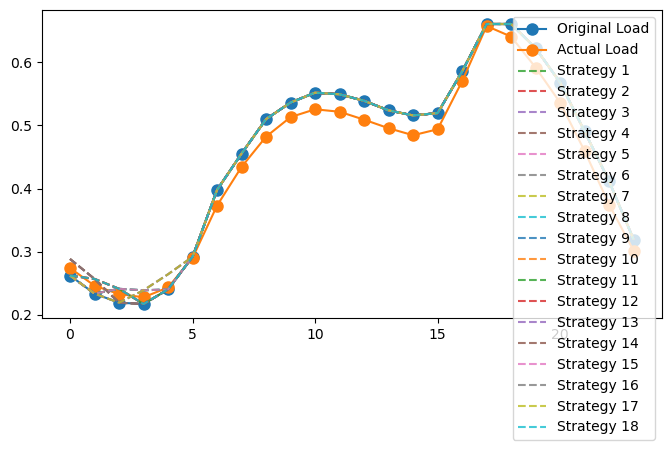

Found 0 relevant failed reflection cases for inquiry 0


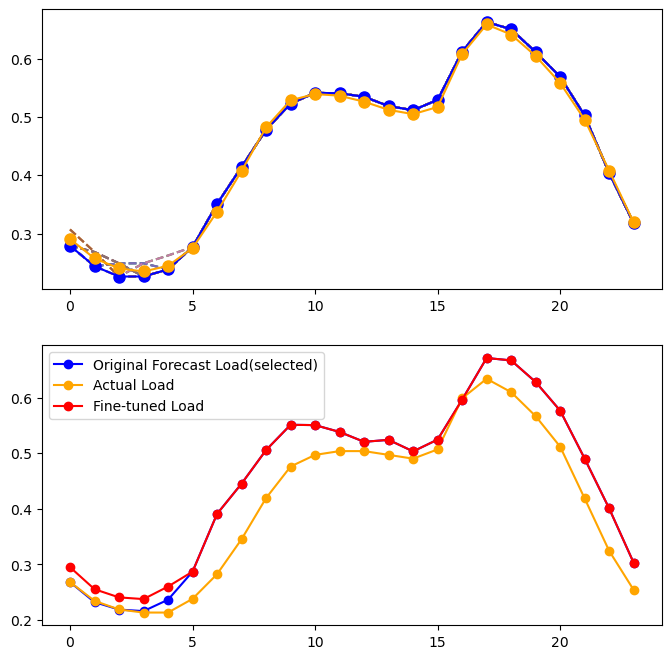

Original cost: 2578.9034243164065, Fine-tuned cost: 2606.8656011000276
Strategy generation attempt #1 (Current valid strategies: 0/5)
Strategy generation attempt #2 (Current valid strategies: 0/5)
Providing actual load values
Discovered valid strategy strategy_4, cost 2555.12, original cost 2578.90, (reduction 23.78)
Discovered valid strategy strategy_10, cost 2555.62, original cost 2578.90, (reduction 23.28)
Strategy generation attempt #3 (Current valid strategies: 2/5)
Providing actual load values
Discovered valid strategy strategy_1, cost 2561.30, original cost 2578.90, (reduction 17.60)
Discovered valid strategy strategy_2, cost 2555.45, original cost 2578.90, (reduction 23.45)
Discovered valid strategy strategy_5, cost 2555.12, original cost 2578.90, (reduction 23.78)
The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the origina

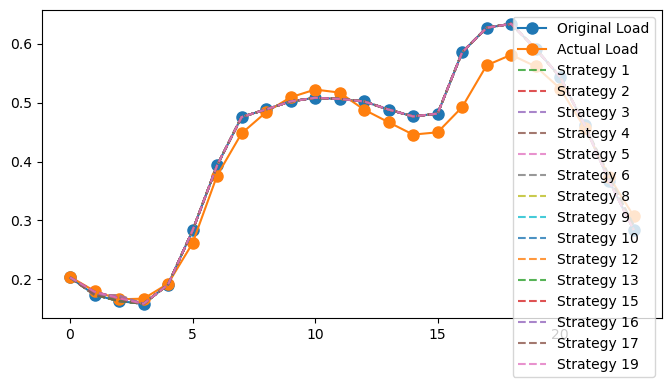

Found 1 relevant failed reflection cases for inquiry 1


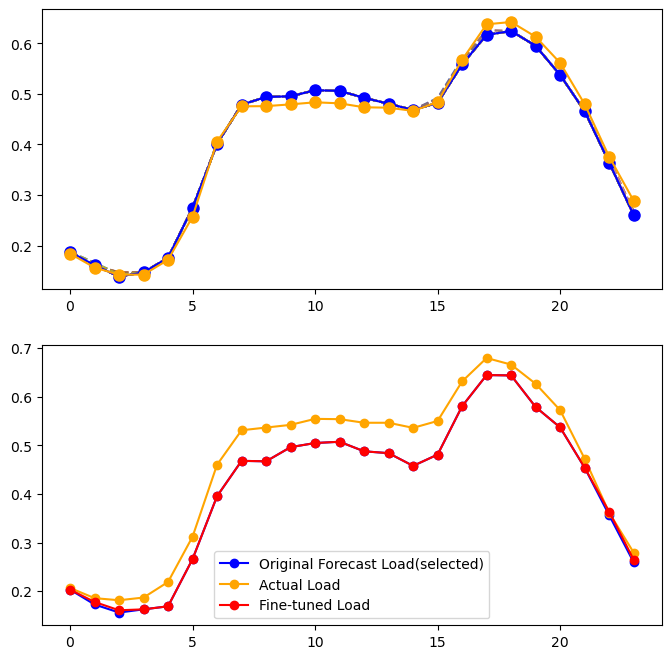

Original cost: 3131.265495117187, Fine-tuned cost: 3117.410544788763
2855.084459716797
2862.1380729443954


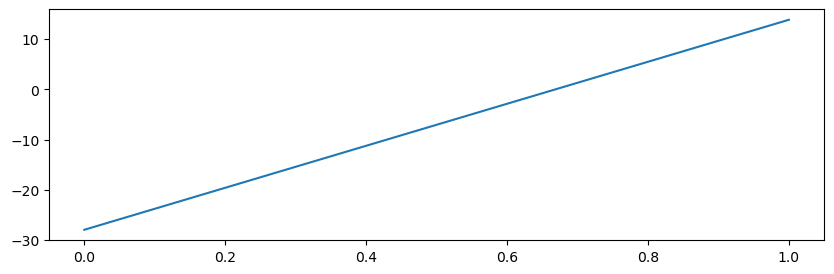

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 3/29
Found 3 similar days for inquiry 2
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 2490.57, original cost 2494.44, (reduction 3.87)
Discovered valid strategy strategy_8, cost 2488.19, original cost 2494.44, (reduction 6.24)
Discovered valid strategy strategy_10, cost 2492.14, original cost 2494.44, (reduction 2.30)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_2, cost 2490.57, original cost 2494.44, (reduction 3.87)
Discovered valid strategy strategy_6, cost 2491.98, original cost 2494.44, (reduction 2.45)
Discovered valid strategy strategy_8, cost 2488.19, original c

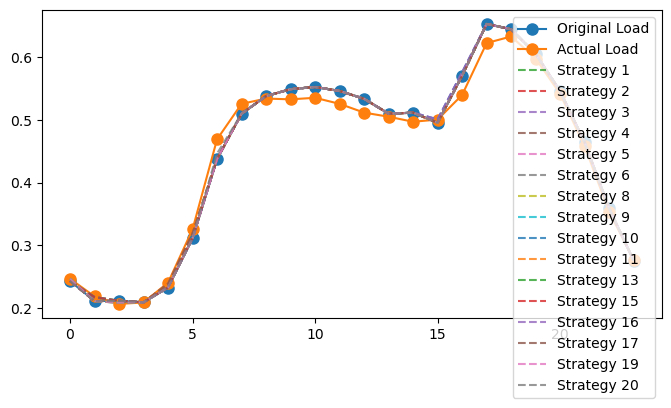

Found 1 relevant failed reflection cases for inquiry 2


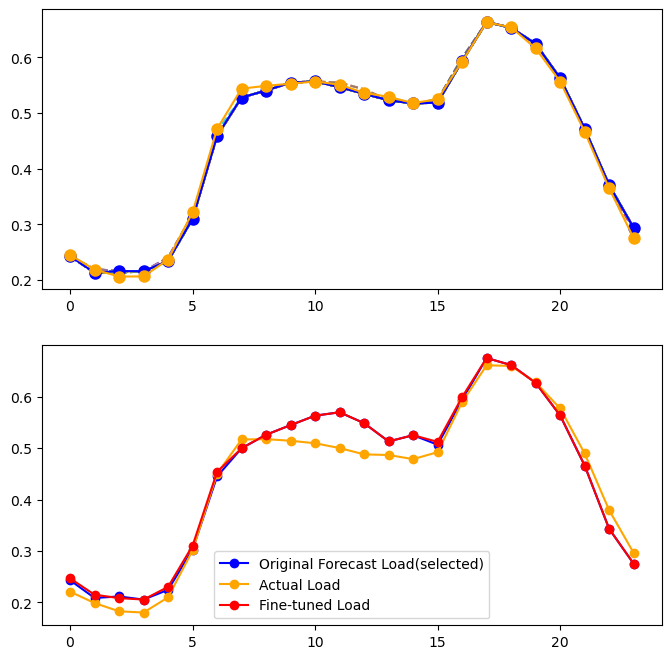

Original cost: 2574.699654296875, Fine-tuned cost: 2580.009867672557
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_2, cost 2555.42, original cost 2574.70, (reduction 19.28)
Discovered valid strategy strategy_3, cost 2571.46, original cost 2574.70, (reduction 3.24)
Discovered valid strategy strategy_4, cost 2566.23, original cost 2574.70, (reduction 8.47)
Discovered valid strategy strategy_7, cost 2567.16, original cost 2574.70, (reduction 7.54)
Discovered valid strategy strategy_9, cost 2566.03, original cost 2574.70, (reduction 8.67)
2761.6228579101567
2768.095337853783


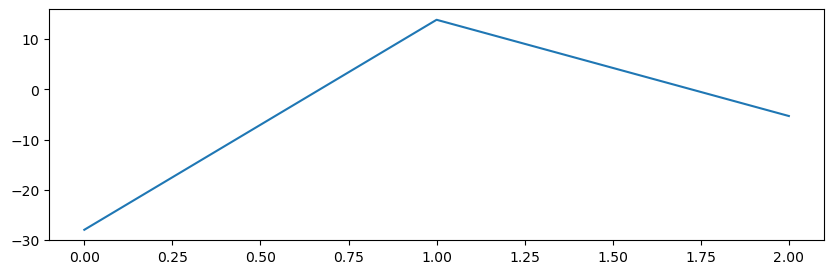

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 4/29
Found 3 similar days for inquiry 3
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_5, cost 2494.14, original cost 2506.02, (reduction 11.88)
Discovered valid strategy strategy_8, cost 2504.79, original cost 2506.02, (reduction 1.23)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Discovered valid strategy strategy_5, cost 2494.14, original cost 2506.02, (reduction 11.88)
Discovered valid strategy strategy_8, cost 2504.79, original cost 2506.02, (reduction 1.23)
Strategy generation attempt #3 (Current valid strategies: 4/20)
Providing actual load values
Discovered valid strategy strategy_1, cost 2504.56, original

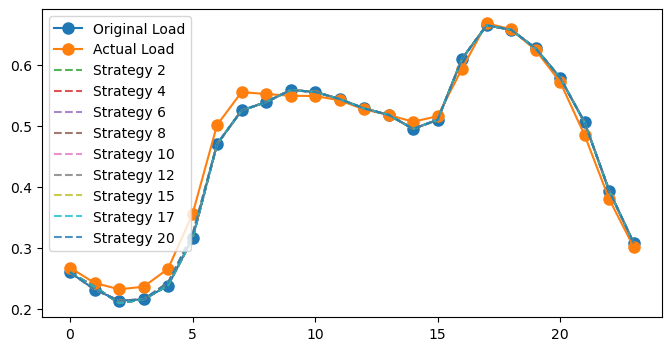

Found 1 relevant failed reflection cases for inquiry 3


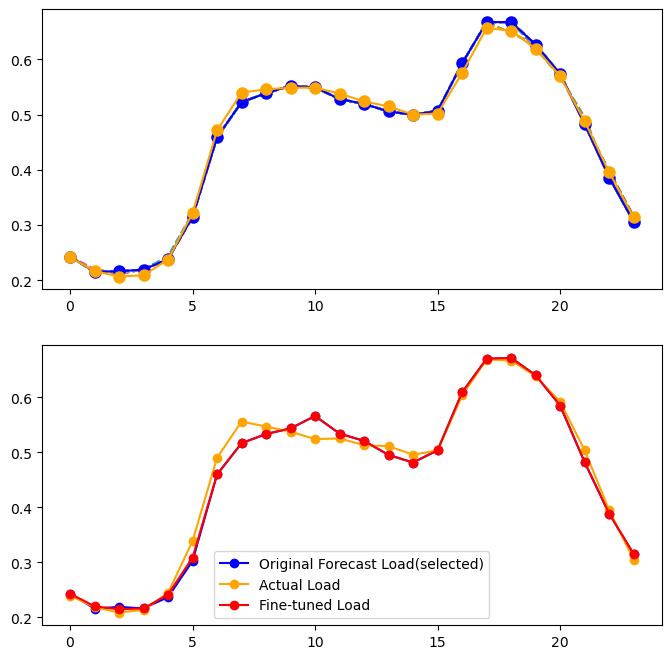

Original cost: 2594.252040527344, Fine-tuned cost: 2583.9086222963633
2719.7801535644535
2722.048658964428


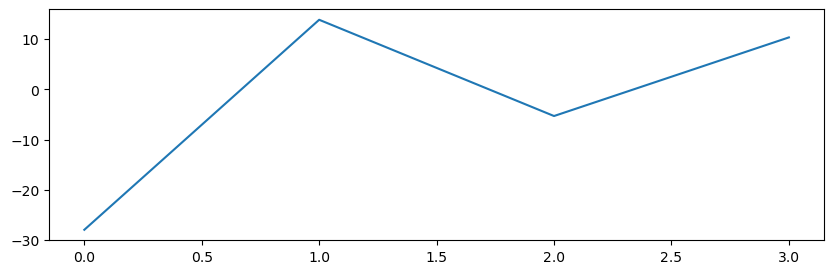

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 5/29
Found 3 similar days for inquiry 4
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_5, cost 2768.99, original cost 2777.87, (reduction 8.88)
Discovered valid strategy strategy_9, cost 2758.00, original cost 2777.87, (reduction 19.87)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Discovered valid strategy strategy_5, cost 2768.99, original cost 2777.87, (reduction 8.88)
Discovered valid strategy strategy_6, cost 2762.70, original cost 2777.87, (reduction 15.17)
Discovered valid strategy strategy_9, cost 2758.00, original cost 2777.87, (reduction 19.87)
Discovered valid strategy strategy_10, cost 2776.19, origina

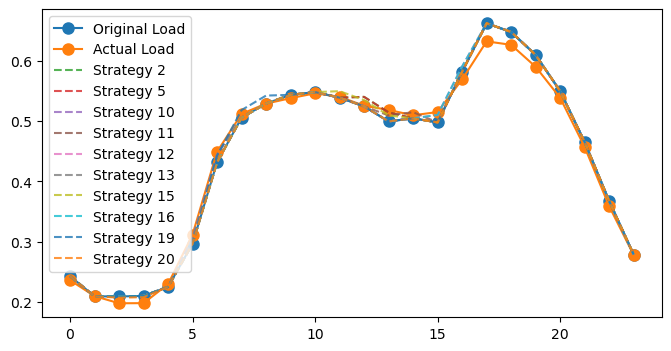

Found 1 relevant failed reflection cases for inquiry 4


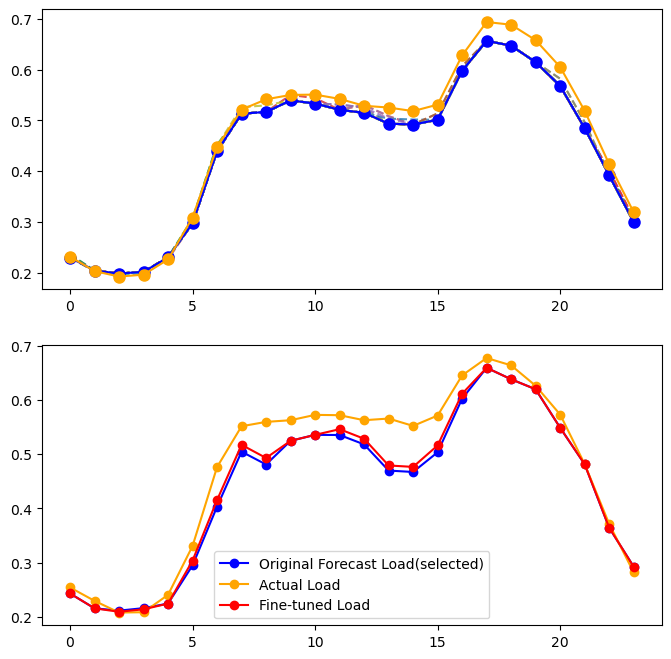

Original cost: 3034.287154296874, Fine-tuned cost: 2957.412869327184
2782.6815537109374
2769.121501036979


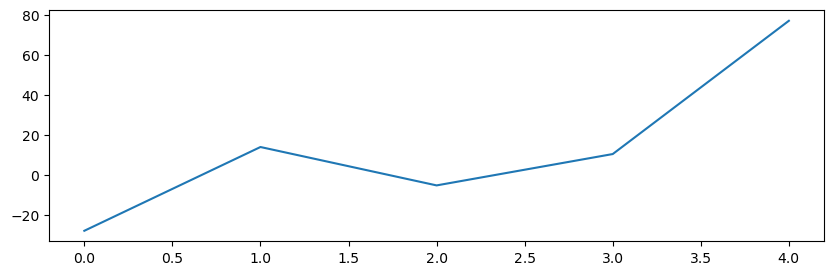

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 6/29
Found 3 similar days for inquiry 5
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_5, cost 2438.67, original cost 2445.32, (reduction 6.65)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Discovered valid strategy strategy_5, cost 2438.67, original cost 2445.32, (reduction 6.65)
Strategy generation attempt #3 (Current valid strategies: 2/20)
Providing actual load values
Discovered valid strategy strategy_5, cost 2431.97, original cost 2445.32, (reduction 13.35)
Strategy generation attempt #4 (Current valid strategies: 3/20)
Providing actual load values
Discovered valid strategy strategy_3, cost 2436.09, original

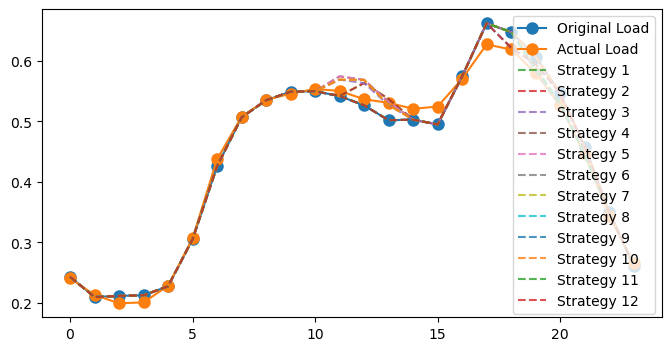

Found 1 relevant failed reflection cases for inquiry 5


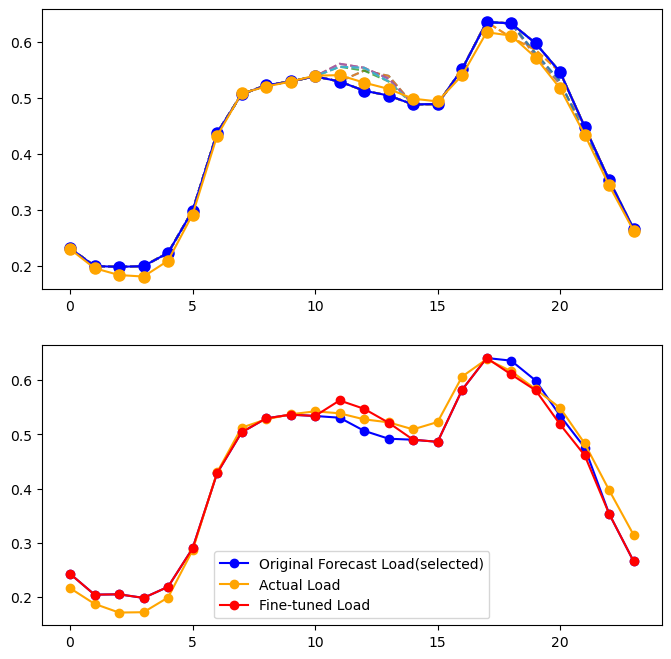

Original cost: 2620.90227734375, Fine-tuned cost: 2608.4151768785623
2755.7183409830727
2742.3371136772435


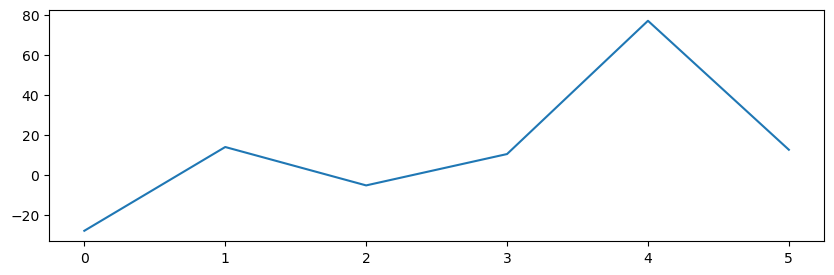

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 7/29
Found 3 similar days for inquiry 6
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_4, cost 2433.40, original cost 2446.71, (reduction 13.30)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Discovered valid strategy strategy_4, cost 2433.40, original cost 2446.71, (reduction 13.30)
Strategy generation attempt #3 (Current valid strategies: 2/20)
Providing actual load values
Discovered valid strategy strategy_4, cost 2436.14, original cost 2446.71, (reduction 10.57)
Strategy generation attempt #4 (Current valid strategies: 3/20)
Providing actual load values
Discovered valid strategy strategy_2, cost 2444.09, origin

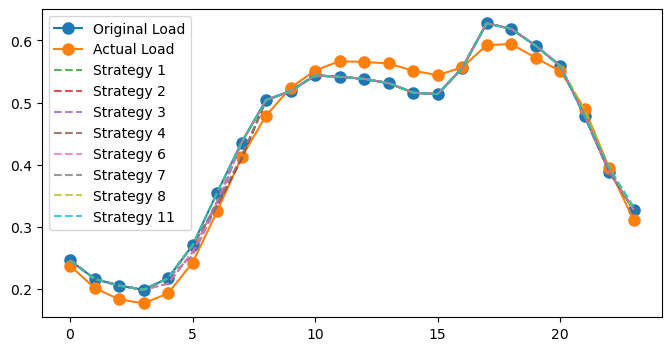

Found 1 relevant failed reflection cases for inquiry 6


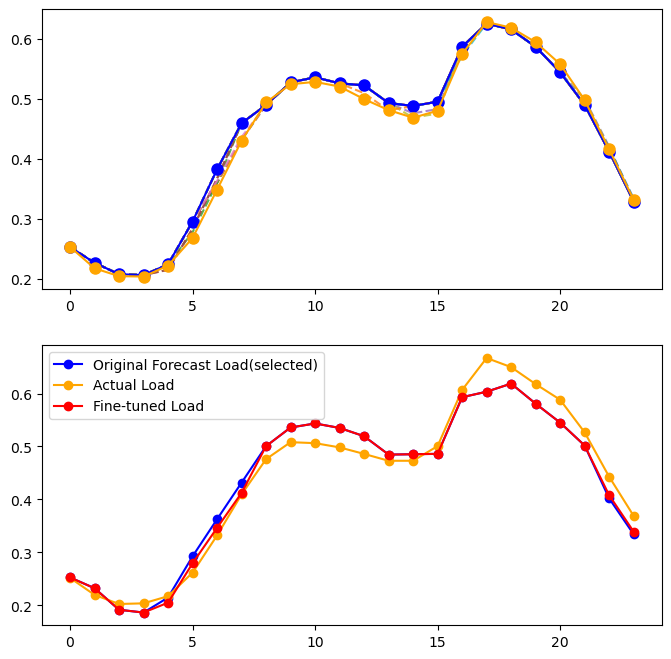

Original cost: 2683.4193647460934, Fine-tuned cost: 2669.617694340247
2745.3899158063614
2731.9486252005295


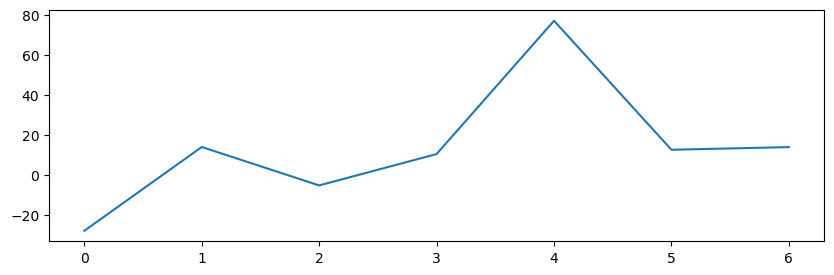

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 8/29
Found 3 similar days for inquiry 7
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 2546.69, original cost 2556.35, (reduction 9.66)
Discovered valid strategy strategy_5, cost 2550.26, original cost 2556.35, (reduction 6.10)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Discovered valid strategy strategy_2, cost 2546.69, original cost 2556.35, (reduction 9.66)
Discovered valid strategy strategy_4, cost 2550.26, original cost 2556.35, (reduction 6.10)
Discovered valid strategy strategy_7, cost 2547.91, original cost 2556.35, (reduction 8.44)
Discovered valid strategy strategy_8, cost 2543.30, original co

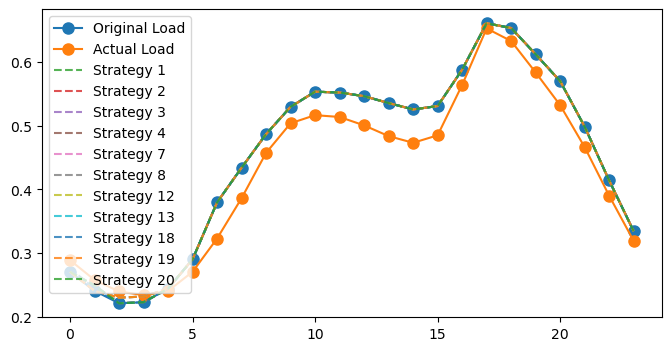

Found 1 relevant failed reflection cases for inquiry 7


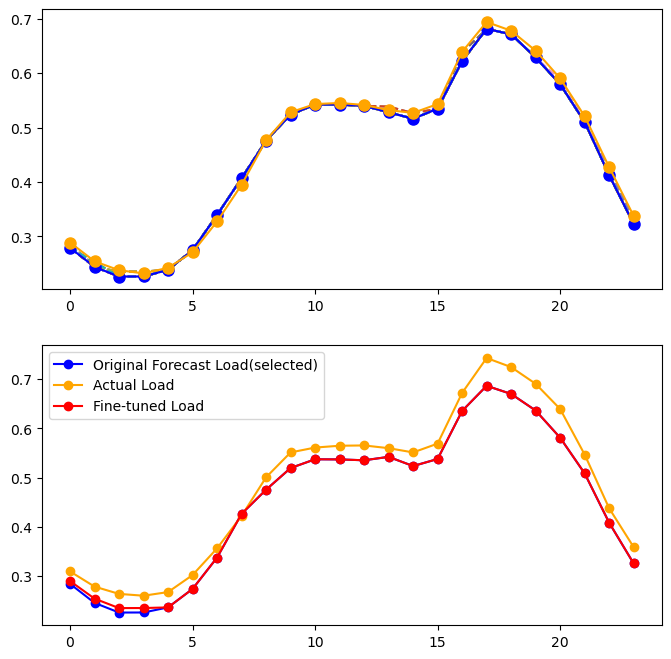

Original cost: 3052.8220673828123, Fine-tuned cost: 3029.6936755729093
2783.8189347534176
2769.1667564970767


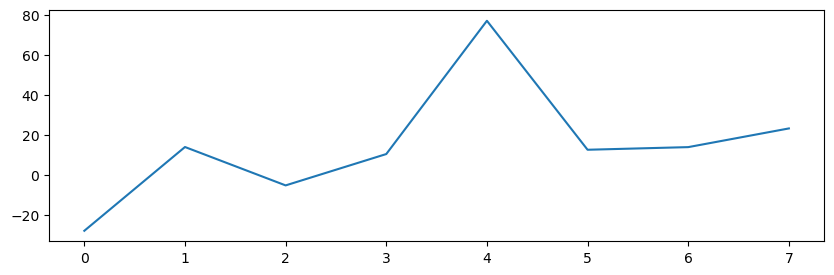

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 9/29
Found 3 similar days for inquiry 8
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 2753.37, original cost 2761.18, (reduction 7.81)
Discovered valid strategy strategy_9, cost 2748.64, original cost 2761.18, (reduction 12.54)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Discovered valid strategy strategy_2, cost 2753.37, original cost 2761.18, (reduction 7.81)
Discovered valid strategy strategy_4, cost 2754.68, original cost 2761.18, (reduction 6.51)
Discovered valid strategy strategy_6, cost 2746.65, original cost 2761.18, (reduction 14.53)
Discovered valid strategy strategy_9, cost 2748.64, original 

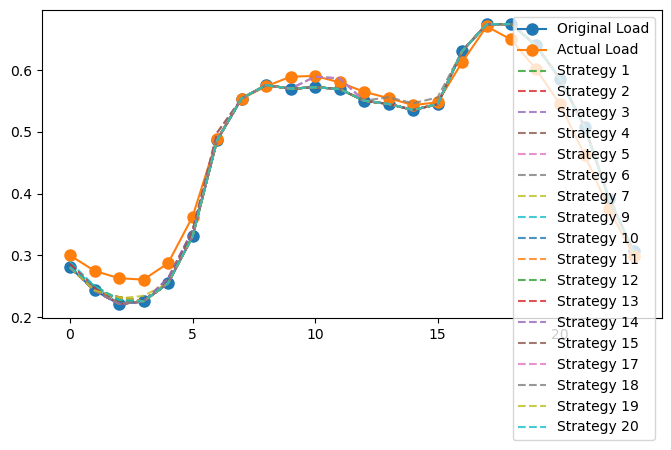

Found 1 relevant failed reflection cases for inquiry 8


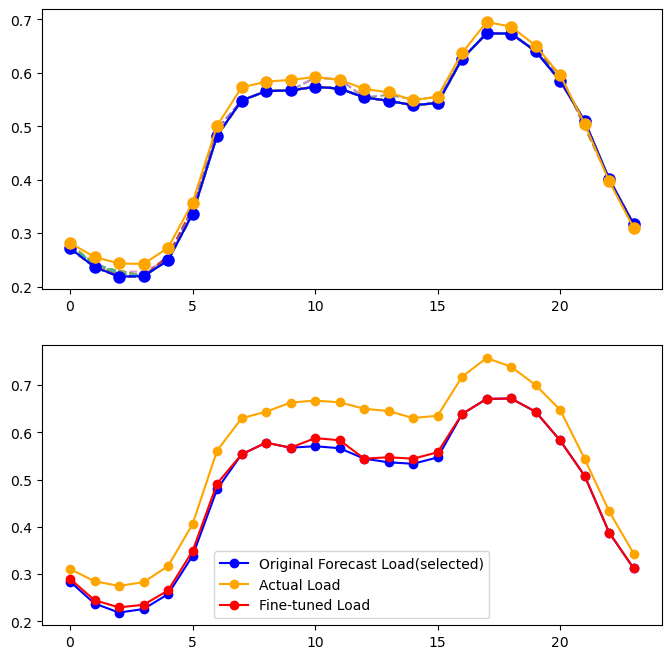

Original cost: 3842.1014096679683, Fine-tuned cost: 3750.398929960191
2901.40587641059
2878.1925535485334


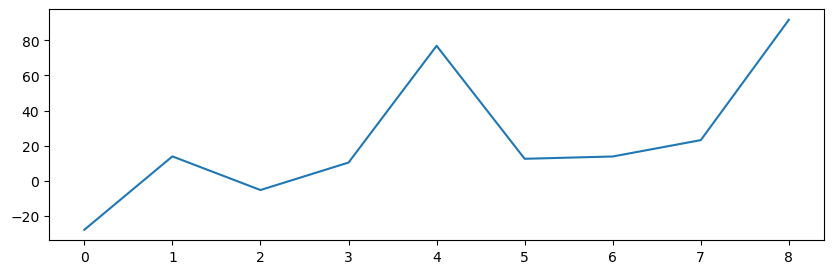

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 10/29
Found 3 similar days for inquiry 9
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 2745.56, original cost 2761.18, (reduction 15.63)
Discovered valid strategy strategy_5, cost 2748.04, original cost 2761.18, (reduction 13.14)
Discovered valid strategy strategy_9, cost 2751.46, original cost 2761.18, (reduction 9.72)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_2, cost 2729.22, original cost 2761.18, (reduction 31.97)
Discovered valid strategy strategy_4, cost 2737.10, original cost 2761.18, (reduction 24.08)
Discovered valid strategy strategy_5, cost 2757.29, origin

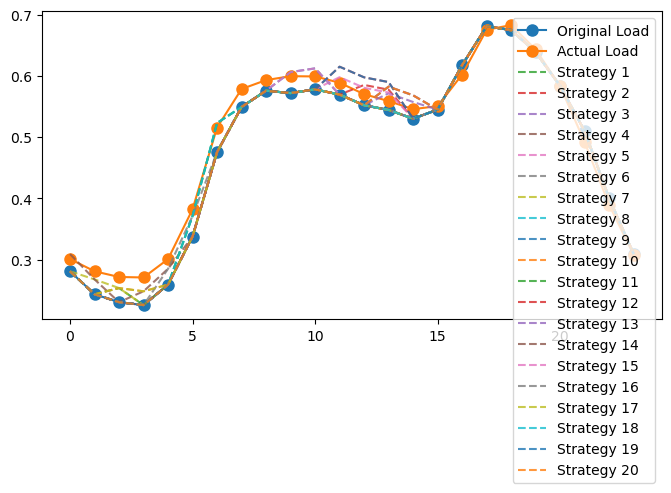

Found 1 relevant failed reflection cases for inquiry 9


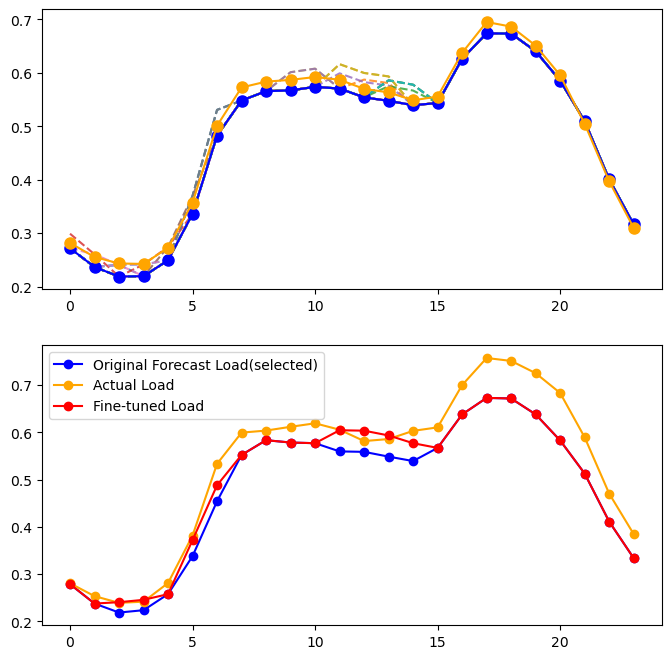

Original cost: 3418.686769042969, Fine-tuned cost: 3251.521032792908
2953.133965673828
2915.525401472971


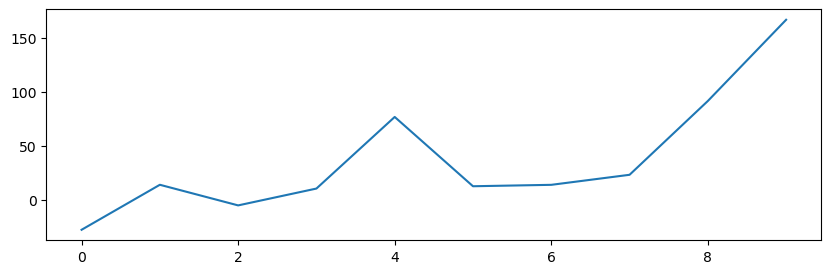

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 11/29
Found 3 similar days for inquiry 10
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 2952.75, original cost 2961.55, (reduction 8.80)
Discovered valid strategy strategy_5, cost 2949.81, original cost 2961.55, (reduction 11.74)
Discovered valid strategy strategy_7, cost 2949.39, original cost 2961.55, (reduction 12.16)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_2, cost 2950.99, original cost 2961.55, (reduction 10.55)
Discovered valid strategy strategy_4, cost 2950.59, original cost 2961.55, (reduction 10.96)
Discovered valid strategy strategy_6, cost 2937.05, origi

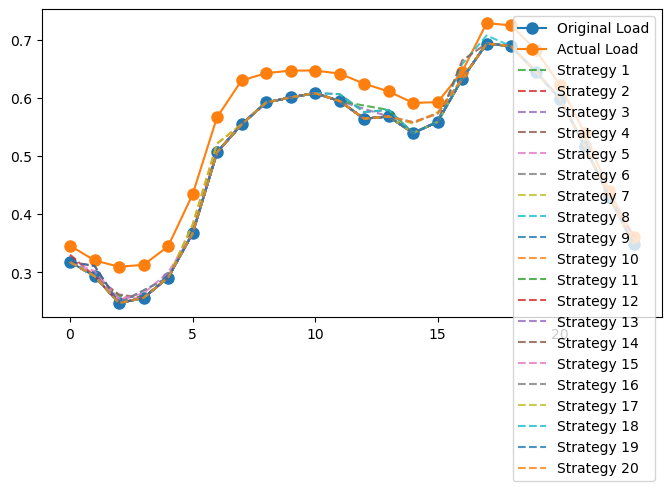

Found 1 relevant failed reflection cases for inquiry 10


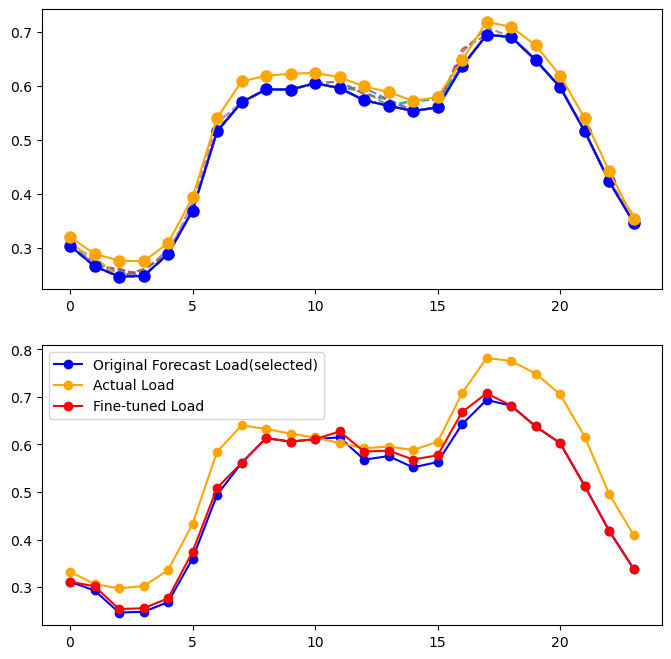

Original cost: 3604.679898925782, Fine-tuned cost: 3494.6944015164913
3012.3654141512784
2968.177128749655


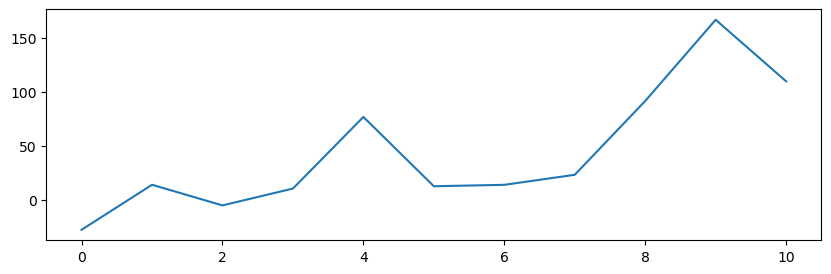

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 12/29
Found 3 similar days for inquiry 11
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 3056.65, original cost 3064.55, (reduction 7.90)
Discovered valid strategy strategy_6, cost 3058.38, original cost 3064.55, (reduction 6.18)
Discovered valid strategy strategy_9, cost 3060.12, original cost 3064.55, (reduction 4.44)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_1, cost 3058.56, original cost 3064.55, (reduction 5.99)
Discovered valid strategy strategy_2, cost 3058.97, original cost 3064.55, (reduction 5.59)
Discovered valid strategy strategy_4, cost 3063.29, original 

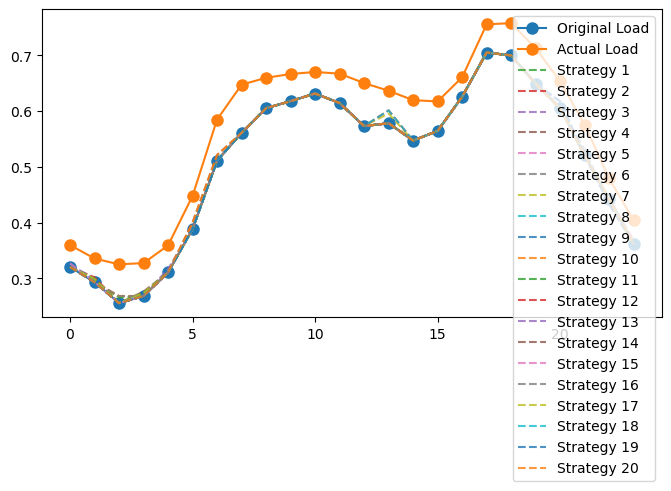

Found 1 relevant failed reflection cases for inquiry 11


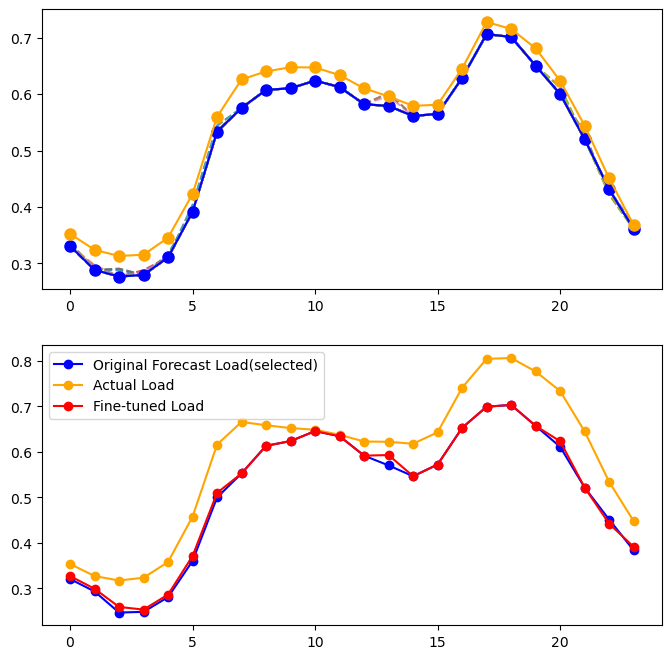

Original cost: 3959.599854980468, Fine-tuned cost: 3895.826950965362
3091.301617553711
3045.4812806009636


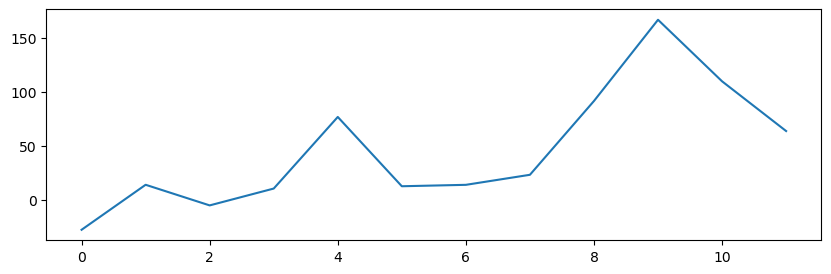

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 13/29
Found 3 similar days for inquiry 12
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 3048.75, original cost 3064.55, (reduction 15.81)
Discovered valid strategy strategy_8, cost 3040.59, original cost 3064.55, (reduction 23.96)
Discovered valid strategy strategy_10, cost 3044.38, original cost 3064.55, (reduction 20.18)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_1, cost 3044.79, original cost 3064.55, (reduction 19.76)
Discovered valid strategy strategy_2, cost 3054.55, original cost 3064.55, (reduction 10.01)
Discovered valid strategy strategy_4, cost 3031.23, ori

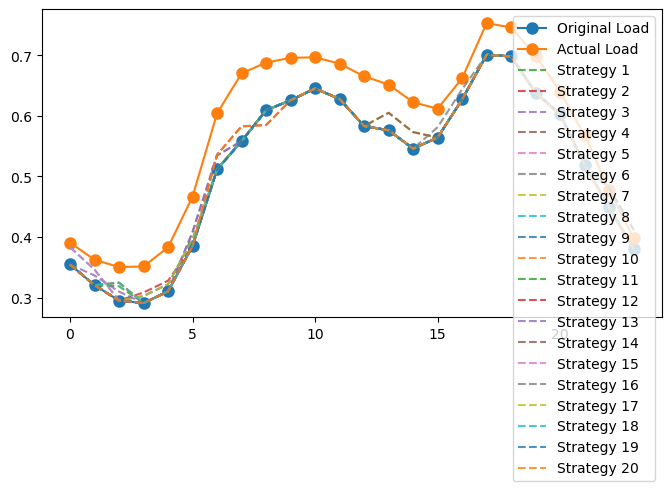

Found 1 relevant failed reflection cases for inquiry 12


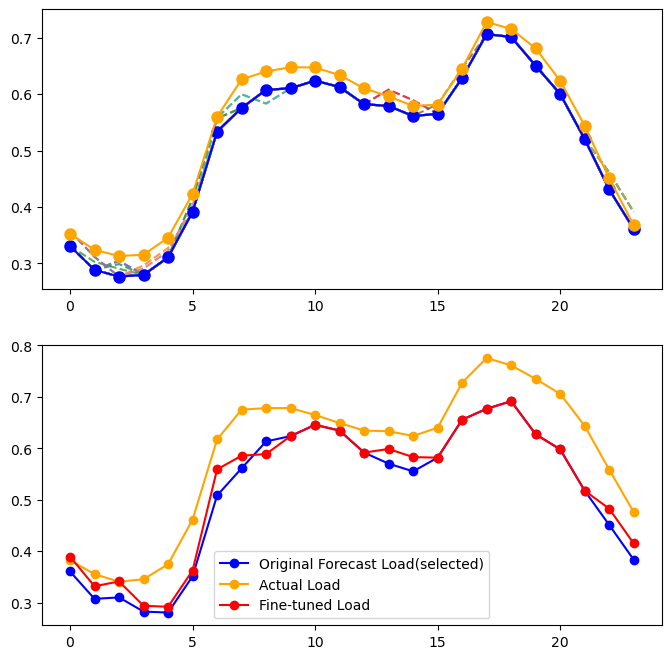

Original cost: 3991.7390185546874, Fine-tuned cost: 3793.9120016937136
3160.566033015325
3103.0528745311753


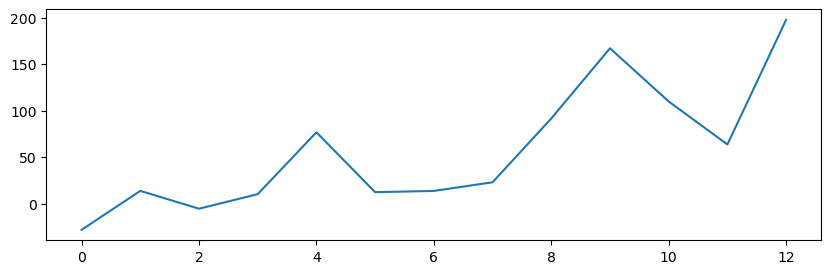

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 14/29
Found 3 similar days for inquiry 13
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 2789.41, original cost 2799.97, (reduction 10.57)
Discovered valid strategy strategy_5, cost 2788.19, original cost 2799.97, (reduction 11.78)
Discovered valid strategy strategy_7, cost 2791.40, original cost 2799.97, (reduction 8.57)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_2, cost 2789.41, original cost 2799.97, (reduction 10.57)
Discovered valid strategy strategy_4, cost 2778.99, original cost 2799.97, (reduction 20.98)
Discovered valid strategy strategy_5, cost 2788.19, origi

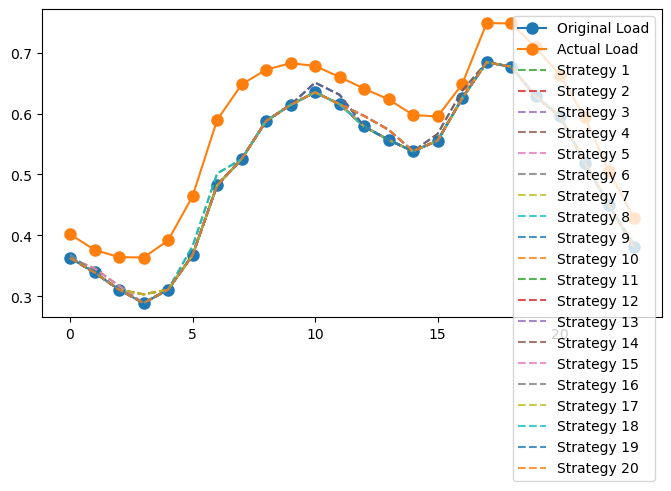

Found 0 relevant failed reflection cases for inquiry 13


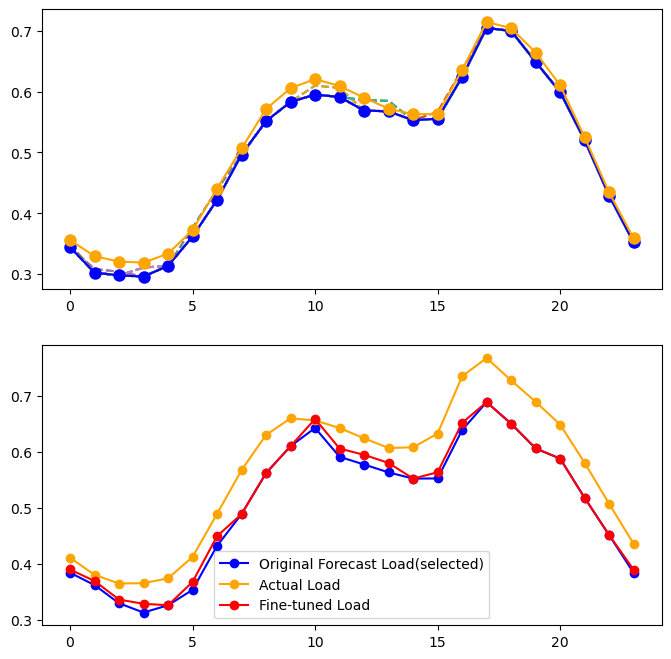

Original cost: 3637.495817382812, Fine-tuned cost: 3525.5688884599595
3194.632446184431
3133.232589811803


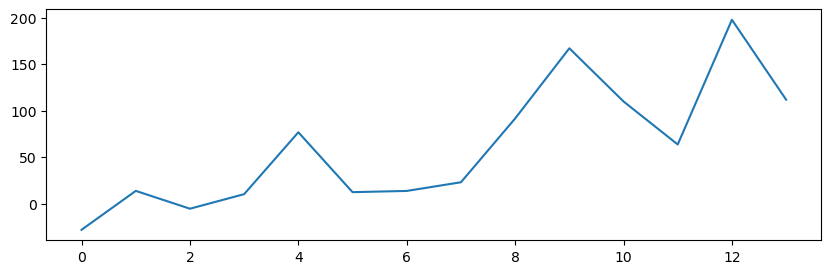

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 15/29
Found 3 similar days for inquiry 14
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2744.13, original cost 2763.33, (reduction 19.20)
Discovered valid strategy strategy_4, cost 2745.30, original cost 2763.33, (reduction 18.03)
Discovered valid strategy strategy_6, cost 2750.57, original cost 2763.33, (reduction 12.76)
Discovered valid strategy strategy_9, cost 2749.35, original cost 2763.33, (reduction 13.98)
Discovered valid strategy strategy_10, cost 2761.26, original cost 2763.33, (reduction 2.06)
Strategy generation attempt #2 (Current valid strategies: 5/20)
Discovered valid strategy strategy_1, cost 2744.13, orig

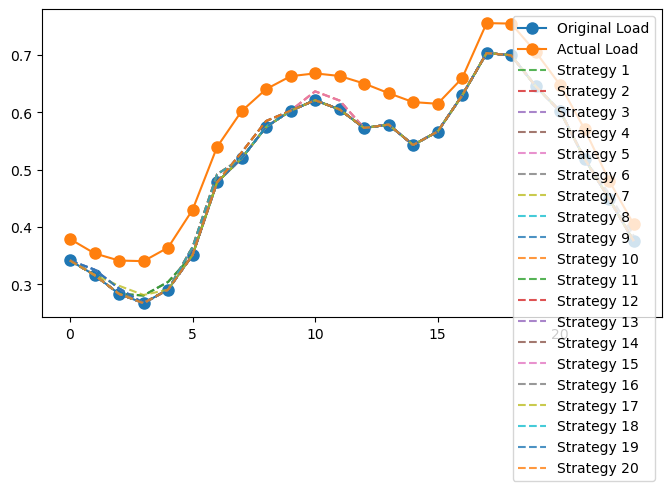

Found 0 relevant failed reflection cases for inquiry 14


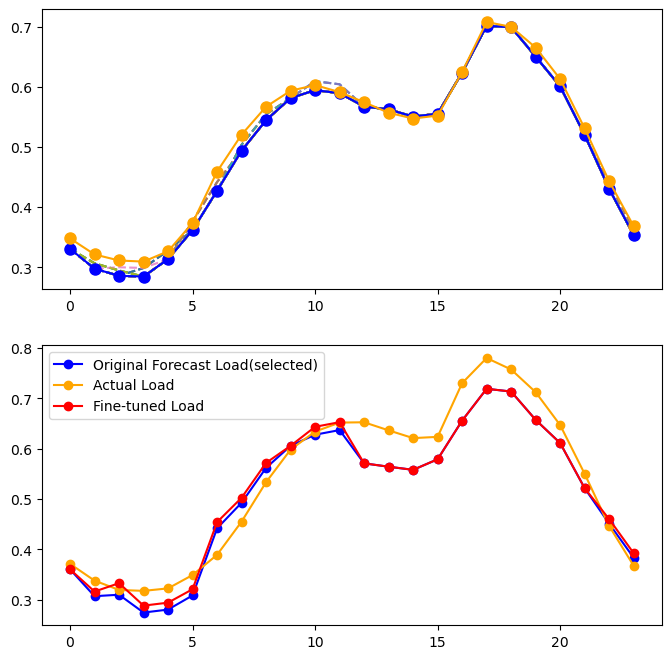

Original cost: 3183.558201171875, Fine-tuned cost: 3146.3777138439773
3193.8941631835937
3134.1089314139476


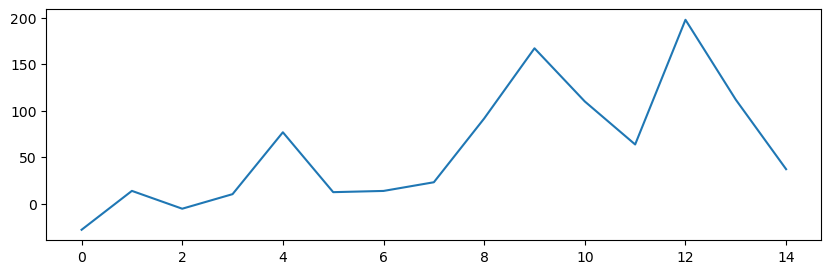

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 16/29
Found 3 similar days for inquiry 15
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2821.62, original cost 2856.00, (reduction 34.37)
Discovered valid strategy strategy_4, cost 2851.97, original cost 2856.00, (reduction 4.03)
Discovered valid strategy strategy_7, cost 2831.91, original cost 2856.00, (reduction 24.09)
Discovered valid strategy strategy_9, cost 2840.78, original cost 2856.00, (reduction 15.22)
Strategy generation attempt #2 (Current valid strategies: 4/20)
Discovered valid strategy strategy_1, cost 2821.74, original cost 2856.00, (reduction 34.25)
Discovered valid strategy strategy_2, cost 2851.97, origi

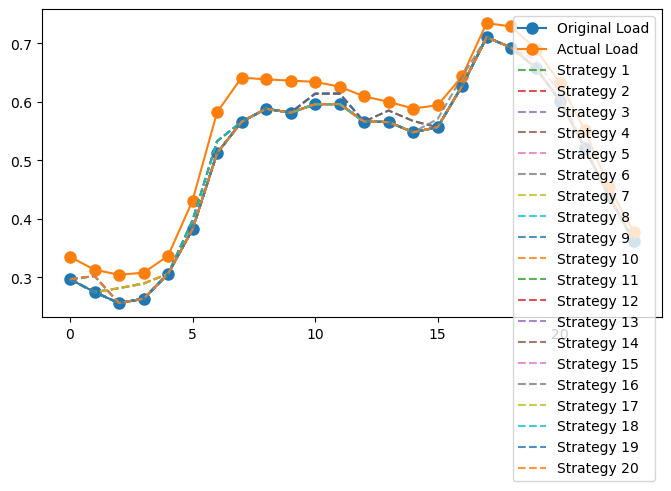

Found 0 relevant failed reflection cases for inquiry 15


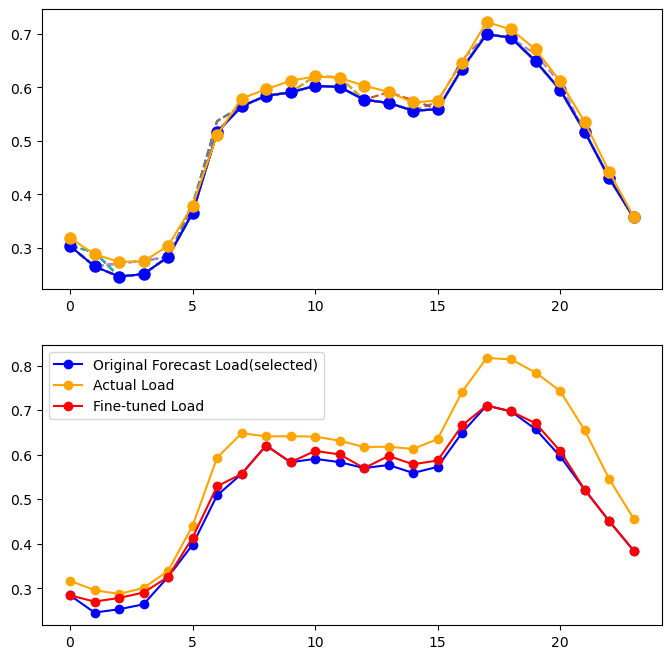

Original cost: 3885.3123837890626, Fine-tuned cost: 3712.702931882974
3237.107801971435
3170.271056443262


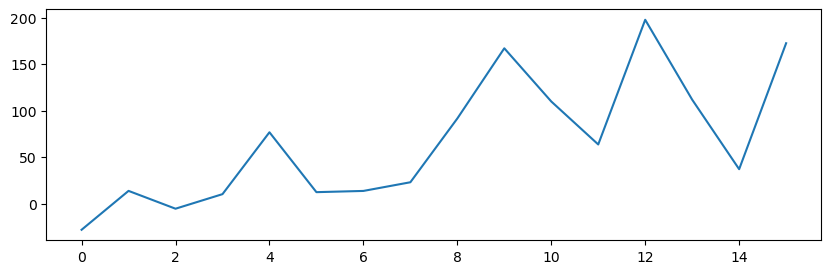

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 17/29
Found 3 similar days for inquiry 16
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 3048.66, original cost 3064.55, (reduction 15.89)
Discovered valid strategy strategy_5, cost 3038.95, original cost 3064.55, (reduction 25.60)
Discovered valid strategy strategy_7, cost 3043.45, original cost 3064.55, (reduction 21.11)
Discovered valid strategy strategy_9, cost 3049.52, original cost 3064.55, (reduction 15.04)
Strategy generation attempt #2 (Current valid strategies: 4/20)
Discovered valid strategy strategy_2, cost 3048.66, original cost 3064.55, (reduction 15.89)
Discovered valid strategy strategy_3, cost 3038.95, orig

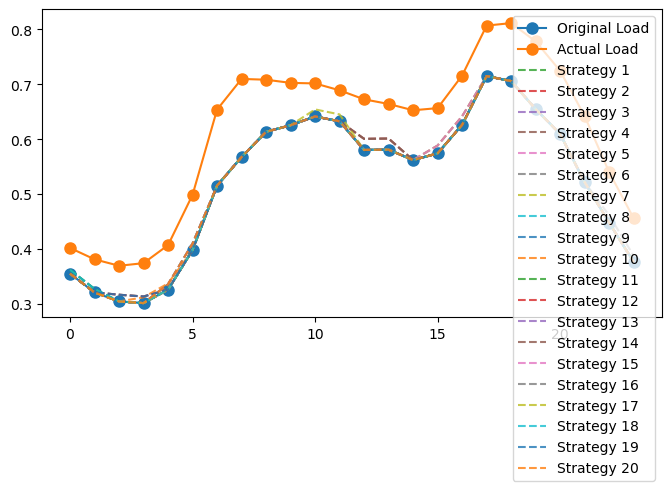

Found 0 relevant failed reflection cases for inquiry 16


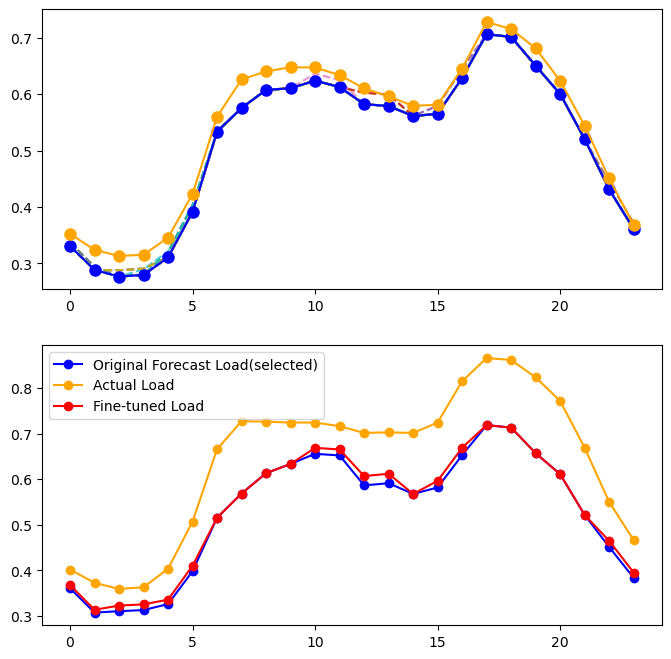

Original cost: 4750.938308105468, Fine-tuned cost: 4620.853909259144
3326.156655273437
3255.5994595500783


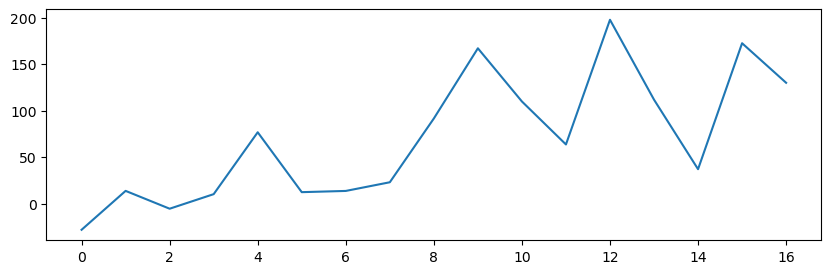

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 18/29
Found 3 similar days for inquiry 17
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 3044.79, original cost 3064.55, (reduction 19.76)
Discovered valid strategy strategy_6, cost 3034.50, original cost 3064.55, (reduction 30.06)
Discovered valid strategy strategy_9, cost 3040.94, original cost 3064.55, (reduction 23.61)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_2, cost 3044.79, original cost 3064.55, (reduction 19.76)
Discovered valid strategy strategy_5, cost 3037.72, original cost 3064.55, (reduction 26.83)
Discovered valid strategy strategy_8, cost 3040.94, orig

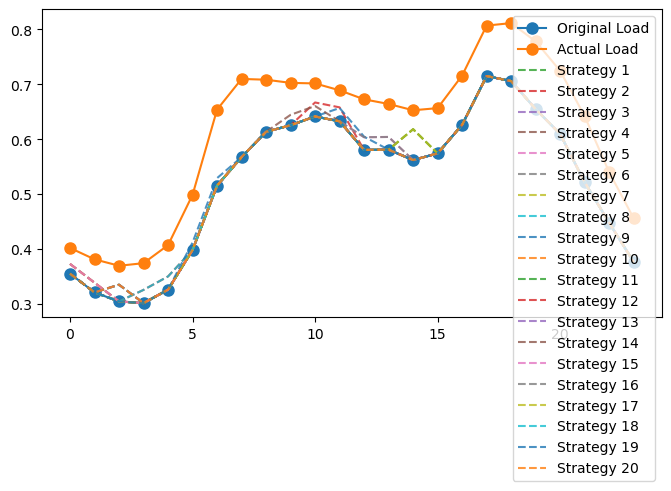

Found 0 relevant failed reflection cases for inquiry 17


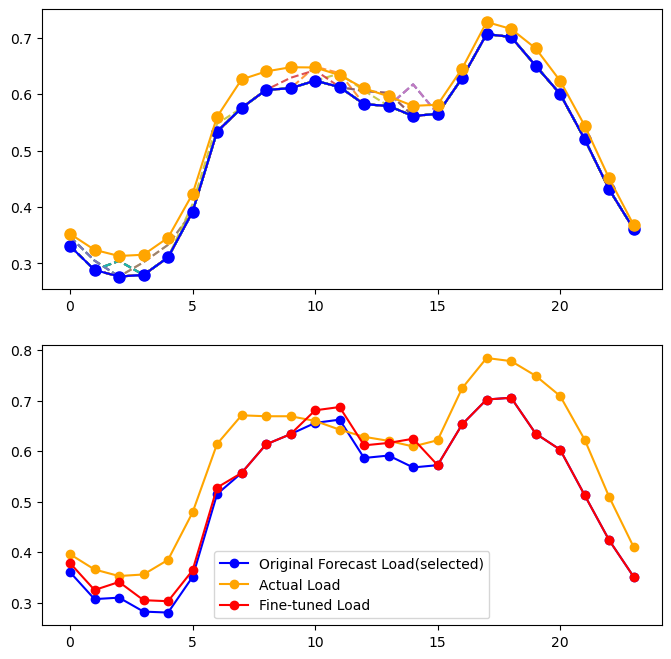

Original cost: 3882.43232421875, Fine-tuned cost: 3732.7213255016877
3357.0608591037326
3282.1062298807237


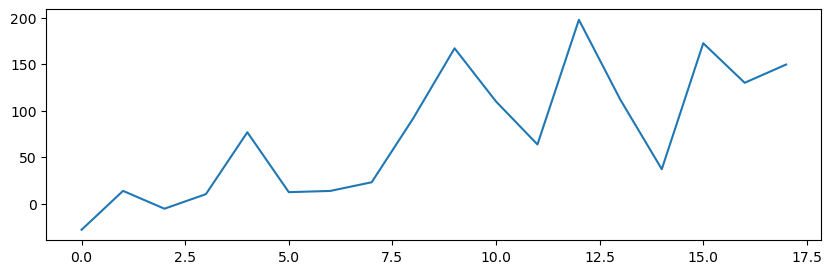

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 19/29
Found 3 similar days for inquiry 18
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_3, cost 2940.51, original cost 2954.15, (reduction 13.63)
Discovered valid strategy strategy_6, cost 2938.10, original cost 2954.15, (reduction 16.05)
Discovered valid strategy strategy_9, cost 2944.66, original cost 2954.15, (reduction 9.49)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_3, cost 2940.51, original cost 2954.15, (reduction 13.63)
Discovered valid strategy strategy_5, cost 2946.02, original cost 2954.15, (reduction 8.13)
Discovered valid strategy strategy_6, cost 2938.10, origin

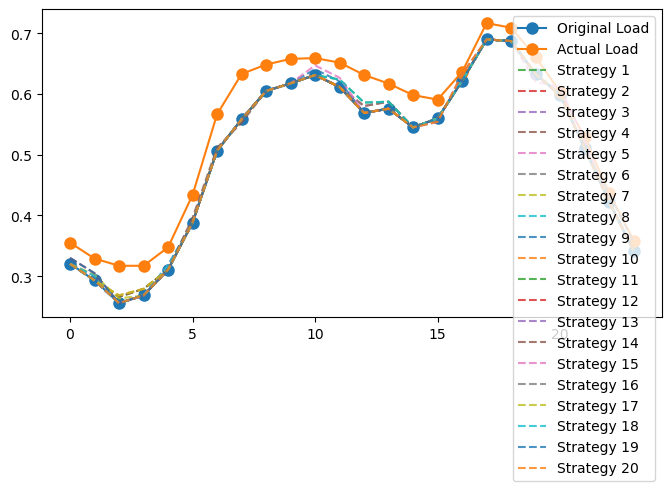

Found 0 relevant failed reflection cases for inquiry 18


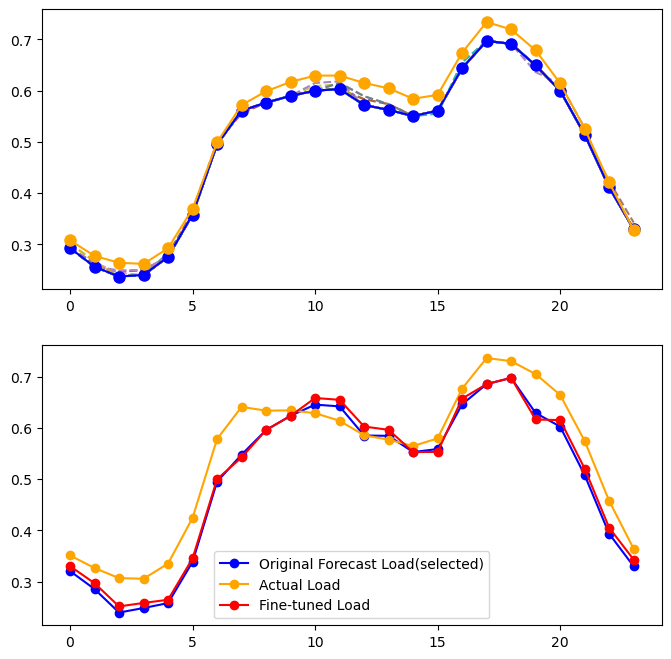

Original cost: 3376.7036972656247, Fine-tuned cost: 3320.5078721675636
3358.0946926912006
3284.1273689484524


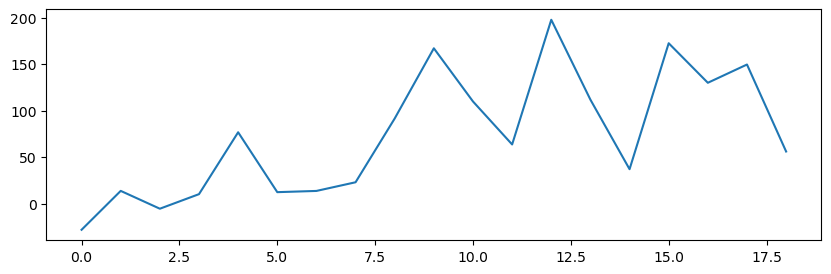

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 20/29
Found 3 similar days for inquiry 19
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 2725.16, original cost 2732.98, (reduction 7.81)
Discovered valid strategy strategy_4, cost 2725.05, original cost 2732.98, (reduction 7.93)
Discovered valid strategy strategy_6, cost 2716.57, original cost 2732.98, (reduction 16.41)
Discovered valid strategy strategy_9, cost 2722.79, original cost 2732.98, (reduction 10.19)
Strategy generation attempt #2 (Current valid strategies: 4/20)
Discovered valid strategy strategy_2, cost 2725.16, original cost 2732.98, (reduction 7.81)
Discovered valid strategy strategy_4, cost 2725.05, origina

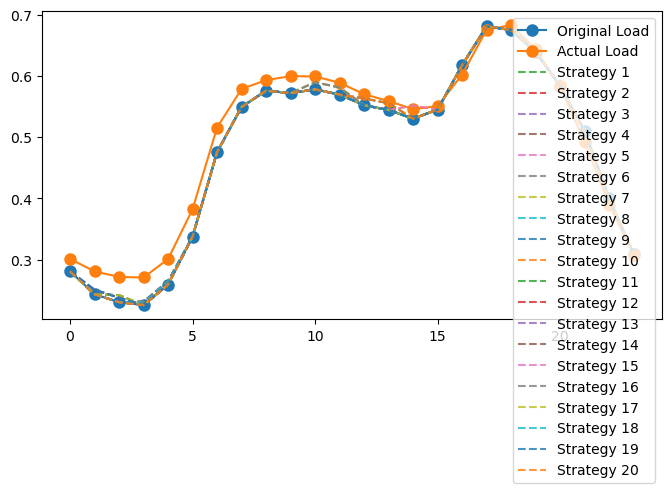

Found 0 relevant failed reflection cases for inquiry 19


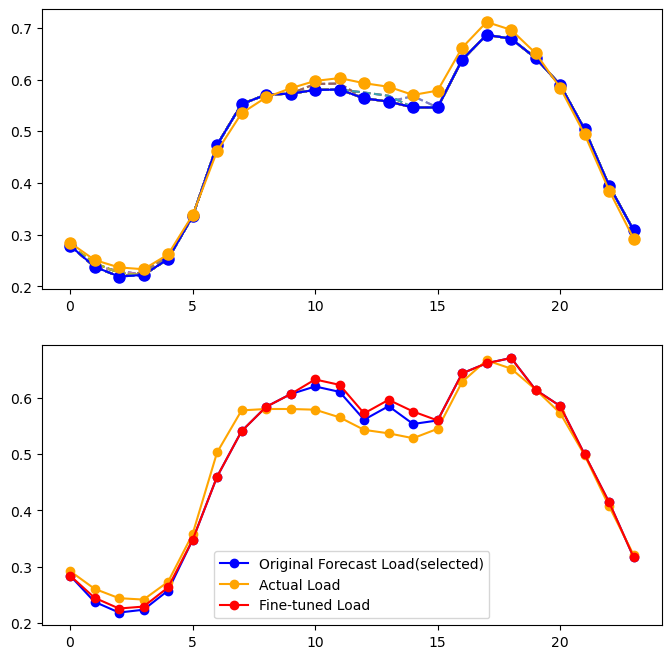

Original cost: 2690.2066416015628, Fine-tuned cost: 2690.470118245611
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_2, cost 2675.48, original cost 2690.21, (reduction 14.73)
Discovered valid strategy strategy_7, cost 2682.74, original cost 2690.21, (reduction 7.47)
Discovered valid strategy strategy_8, cost 2678.57, original cost 2690.21, (reduction 11.63)
Strategy generation attempt #2 (Current valid strategies: 3/5)
Providing actual load values
Discovered valid strategy strategy_2, cost 2674.58, original cost 2690.21, (reduction 15.63)
Discovered valid strategy strategy_7, cost 2673.87, original cost 2690.21, (reduction 16.33)
3324.7002901367186
3254.44450641331


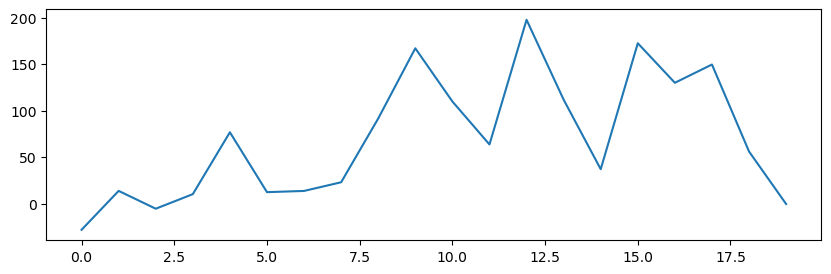

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 21/29
Found 3 similar days for inquiry 20
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Strategy generation attempt #2 (Current valid strategies: 0/20)
Discovered valid strategy strategy_5, cost 2448.66, original cost 2457.35, (reduction 8.69)
Discovered valid strategy strategy_7, cost 2455.23, original cost 2457.35, (reduction 2.12)
Discovered valid strategy strategy_9, cost 2453.46, original cost 2457.35, (reduction 3.90)
Strategy generation attempt #3 (Current valid strategies: 3/20)
Providing actual load values
Discovered valid strategy strategy_5, cost 2448.66, original cost 2457.35, (reduction 8.69)
Discovered valid strategy strategy_6, cost 2455.23, original

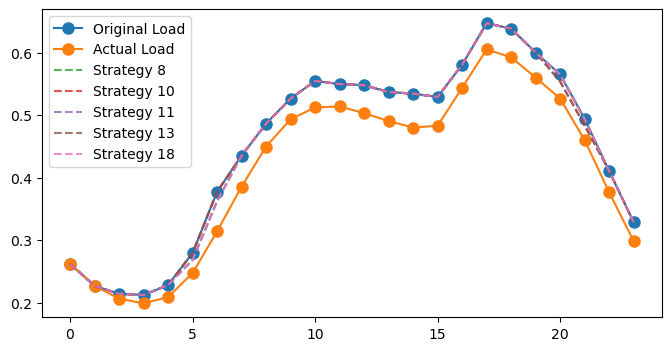

Found 1 relevant failed reflection cases for inquiry 20


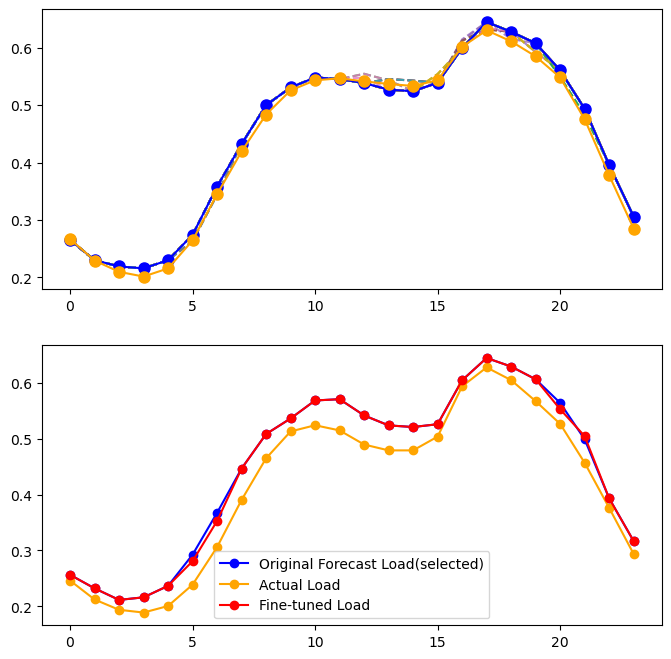

Original cost: 2538.762943359375, Fine-tuned cost: 2530.4090044653776
3287.2747021949403
3219.9666253681708


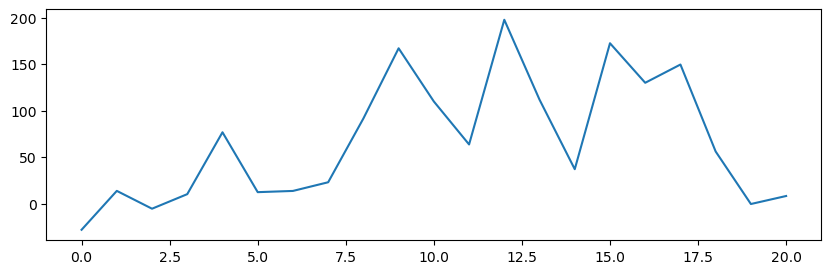

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 22/29
Found 3 similar days for inquiry 21
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Strategy generation attempt #2 (Current valid strategies: 0/20)
Discovered valid strategy strategy_8, cost 2431.31, original cost 2433.64, (reduction 2.33)
Strategy generation attempt #3 (Current valid strategies: 1/20)
Providing actual load values
Discovered valid strategy strategy_4, cost 2429.79, original cost 2433.64, (reduction 3.85)
Discovered valid strategy strategy_7, cost 2432.24, original cost 2433.64, (reduction 1.40)
Strategy generation attempt #4 (Current valid strategies: 3/20)
Providing actual load values
Discovered valid strategy strategy_4, cost 2429.79, origina

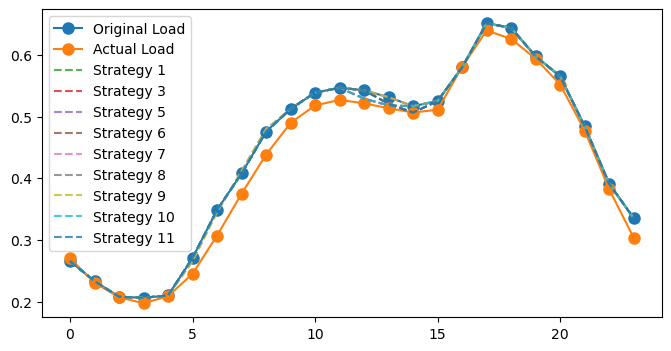

Found 1 relevant failed reflection cases for inquiry 21


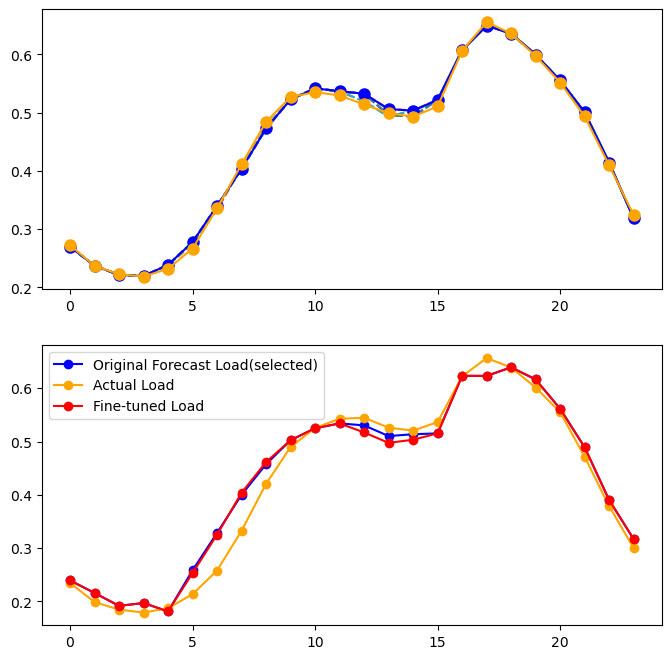

Original cost: 2502.7562250976566, Fine-tuned cost: 2528.268514037618
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_6, cost 2500.44, original cost 2502.76, (reduction 2.31)
Discovered valid strategy strategy_8, cost 2500.64, original cost 2502.76, (reduction 2.12)
Discovered valid strategy strategy_9, cost 2500.07, original cost 2502.76, (reduction 2.68)
Strategy generation attempt #2 (Current valid strategies: 3/5)
Providing actual load values
Discovered valid strategy strategy_3, cost 2490.59, original cost 2502.76, (reduction 12.17)
Discovered valid strategy strategy_5, cost 2501.48, original cost 2502.76, (reduction 1.28)
3251.6147714177914
3188.5258021258724


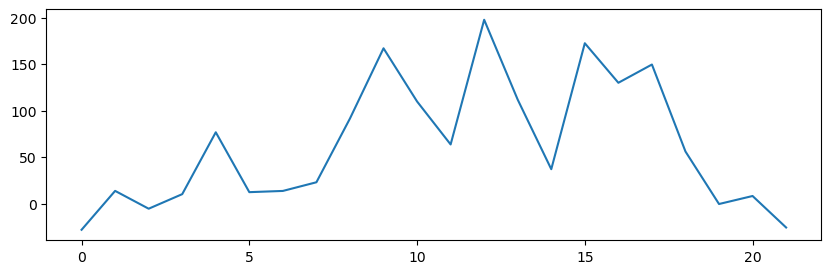

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 23/29
Found 3 similar days for inquiry 22
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_8, cost 2570.00, original cost 2577.24, (reduction 7.24)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Discovered valid strategy strategy_3, cost 2571.17, original cost 2577.24, (reduction 6.07)
Discovered valid strategy strategy_6, cost 2572.07, original cost 2577.24, (reduction 5.17)
Discovered valid strategy strategy_8, cost 2570.00, original cost 2577.24, (reduction 7.24)
Strategy generation attempt #3 (Current valid strategies: 4/20)
Providing actual load values
Discovered valid strategy strategy_3, cost 2571.17, original

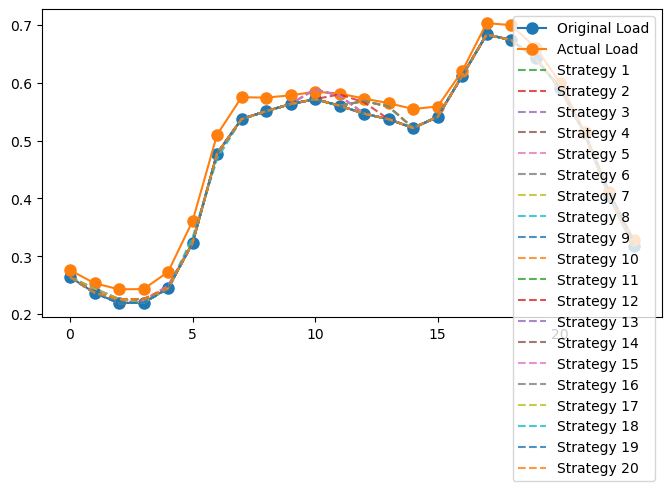

Found 1 relevant failed reflection cases for inquiry 22


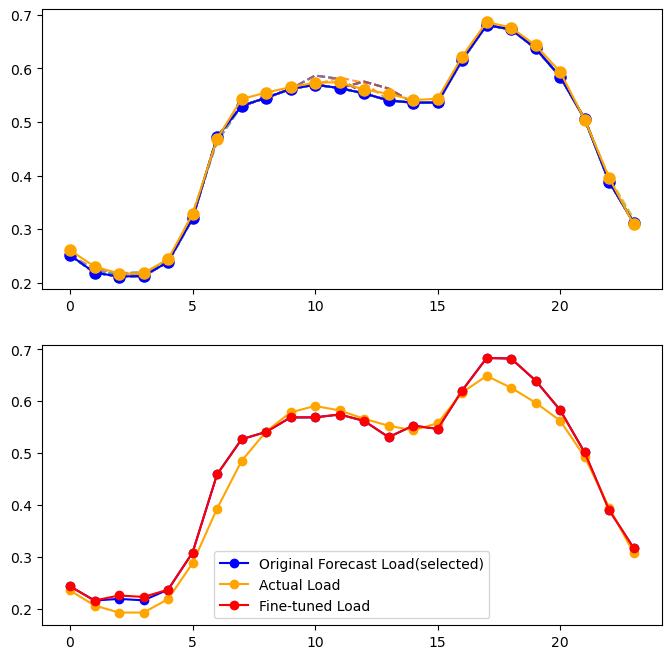

Original cost: 2585.076229492188, Fine-tuned cost: 2588.486196313024
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_7, cost 2577.82, original cost 2585.08, (reduction 7.26)
Discovered valid strategy strategy_8, cost 2580.61, original cost 2585.08, (reduction 4.46)
Discovered valid strategy strategy_9, cost 2582.07, original cost 2585.08, (reduction 3.01)
Strategy generation attempt #2 (Current valid strategies: 3/5)
Providing actual load values
Discovered valid strategy strategy_4, cost 2572.43, original cost 2585.08, (reduction 12.65)
Discovered valid strategy strategy_7, cost 2577.82, original cost 2585.08, (reduction 7.26)
3222.63483481233
3162.4371236122706


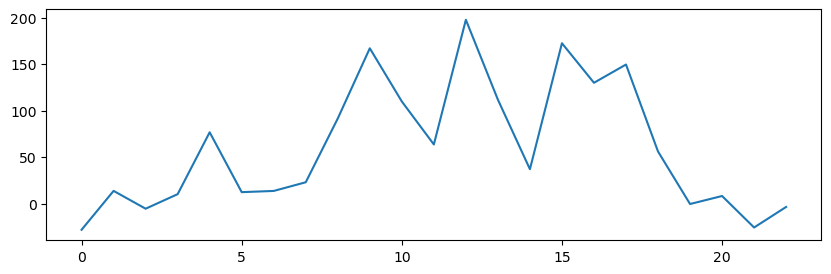

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 24/29
Found 3 similar days for inquiry 23
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_7, cost 2515.05, original cost 2523.09, (reduction 8.04)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Discovered valid strategy strategy_5, cost 2514.37, original cost 2523.09, (reduction 8.72)
Discovered valid strategy strategy_7, cost 2515.05, original cost 2523.09, (reduction 8.04)
Discovered valid strategy strategy_10, cost 2522.02, original cost 2523.09, (reduction 1.06)
Strategy generation attempt #3 (Current valid strategies: 4/20)
Providing actual load values
Discovered valid strategy strategy_4, cost 2514.40, origina

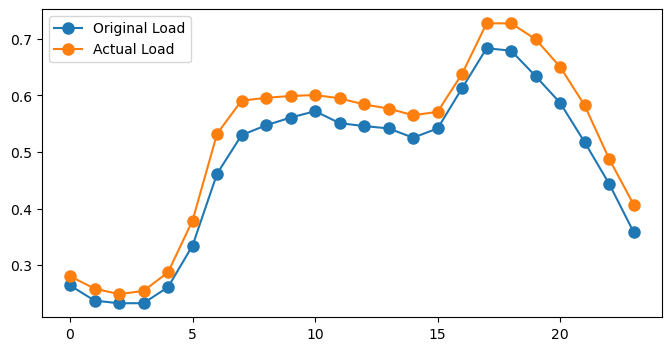

Inquiry 23: No valid strategy found, using original curve as fine-tuned result.
3199.9702701822916
3142.280796948901


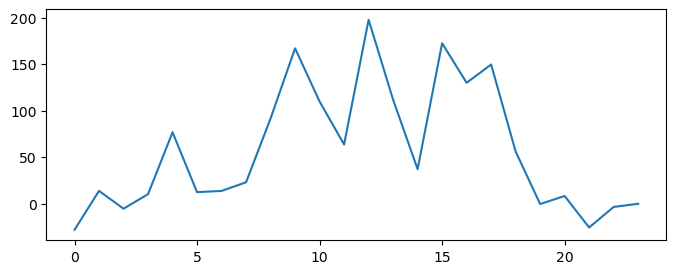

Processing inquiry 25/29
Found 3 similar days for inquiry 24
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 2479.85, original cost 2485.45, (reduction 5.60)
Discovered valid strategy strategy_7, cost 2482.28, original cost 2485.45, (reduction 3.17)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Discovered valid strategy strategy_2, cost 2479.85, original cost 2485.45, (reduction 5.60)
Discovered valid strategy strategy_3, cost 2482.28, original cost 2485.45, (reduction 3.17)
Discovered valid strategy strategy_4, cost 2480.19, original cost 2485.45, (reduction 5.26)
Strategy generation attempt #3 (Current valid strategies: 5/20)
Providing actual load values
Discovered valid strategy strategy_3, cost 2480.53, original cost 2485.45, (reduction 4.91)
Discovered valid strategy strategy_5, cost 2480.19, original cost 2485.45, (reduction 5.26)
Discovered valid stra

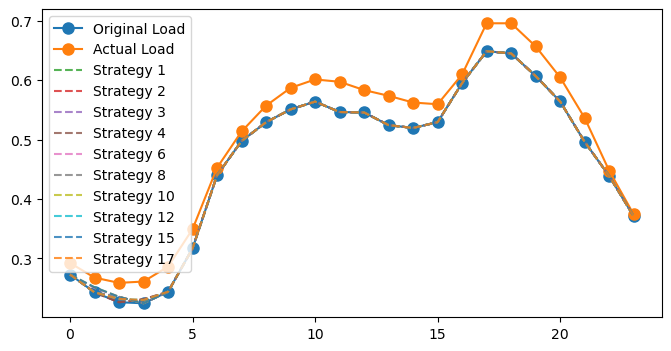

Found 1 relevant failed reflection cases for inquiry 24


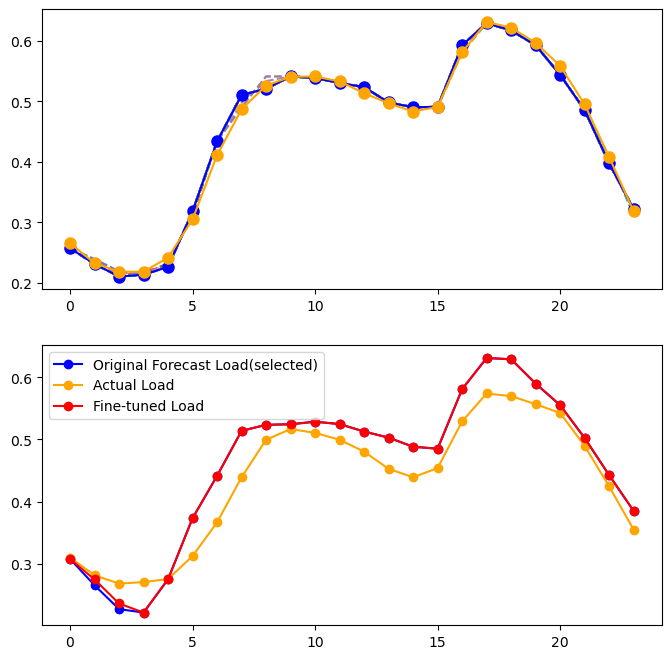

Original cost: 2631.4863002929687, Fine-tuned cost: 2618.387267350361
3177.2309113867186
3121.3250557649594


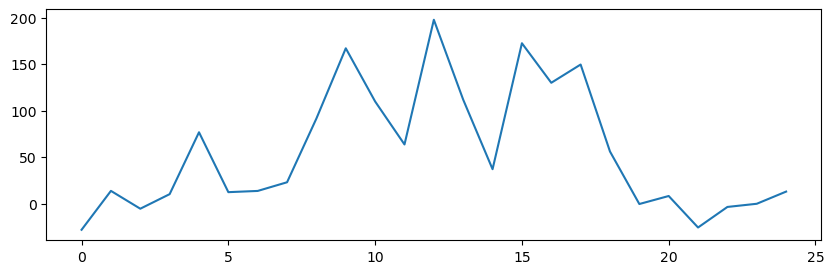

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [23]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 26/29
Found 3 similar days for inquiry 25
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_4, cost 2685.74, original cost 2702.94, (reduction 17.20)
Discovered valid strategy strategy_8, cost 2687.11, original cost 2702.94, (reduction 15.84)
Discovered valid strategy strategy_10, cost 2680.55, original cost 2702.94, (reduction 22.39)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_4, cost 2685.74, original cost 2702.94, (reduction 17.20)
Discovered valid strategy strategy_6, cost 2684.77, original cost 2702.94, (reduction 18.17)
Discovered valid strategy strategy_8, cost 2687.11, o

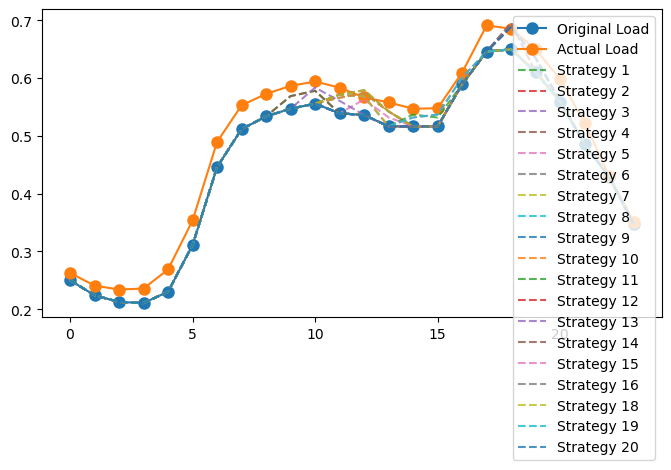

Found 1 relevant failed reflection cases for inquiry 25


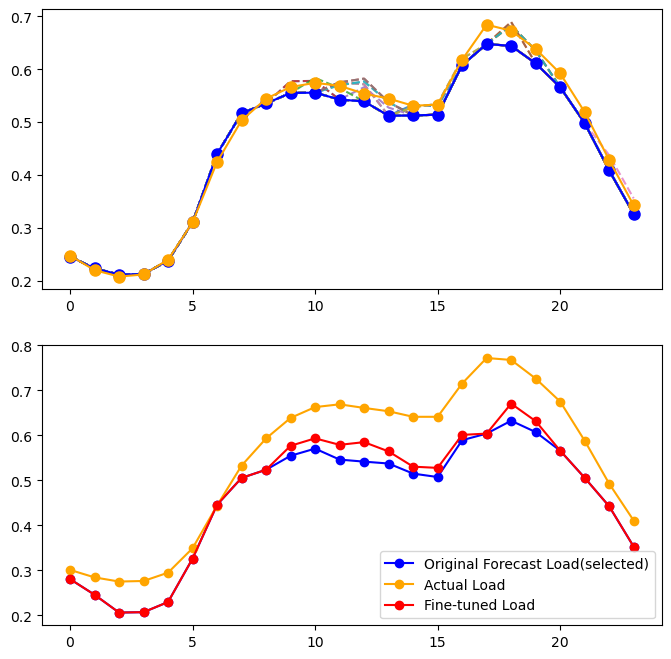

Original cost: 4071.462516113281, Fine-tuned cost: 3889.1077652783815
3211.6244346454328
3150.8551599770144


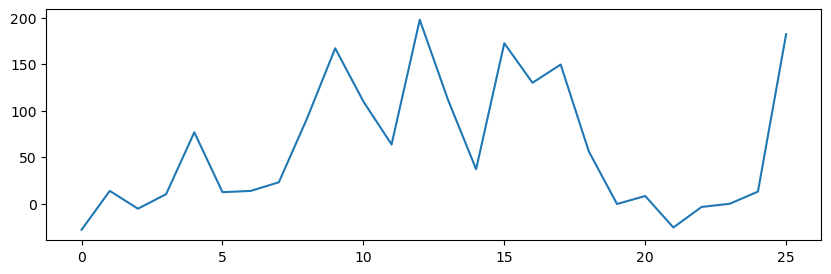

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [23]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 27/29
Found 3 similar days for inquiry 26
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 2943.96, original cost 2961.55, (reduction 17.59)
Discovered valid strategy strategy_6, cost 2939.25, original cost 2961.55, (reduction 22.30)
Discovered valid strategy strategy_8, cost 2935.27, original cost 2961.55, (reduction 26.27)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_2, cost 2931.68, original cost 2961.55, (reduction 29.87)
Discovered valid strategy strategy_4, cost 2942.12, original cost 2961.55, (reduction 19.43)
Discovered valid strategy strategy_8, cost 2954.30, or

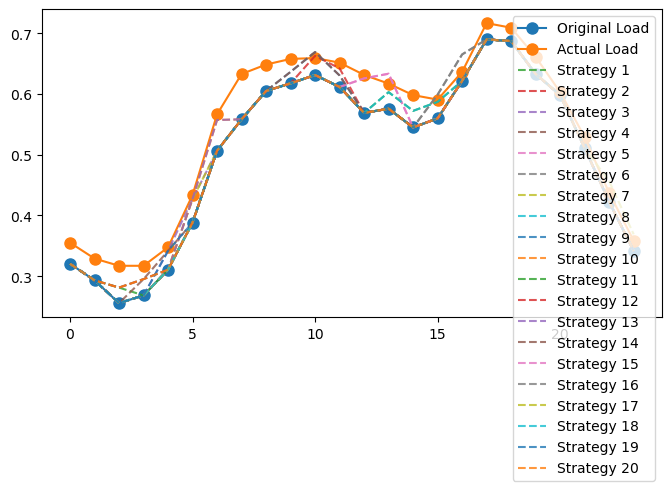

Found 1 relevant failed reflection cases for inquiry 26


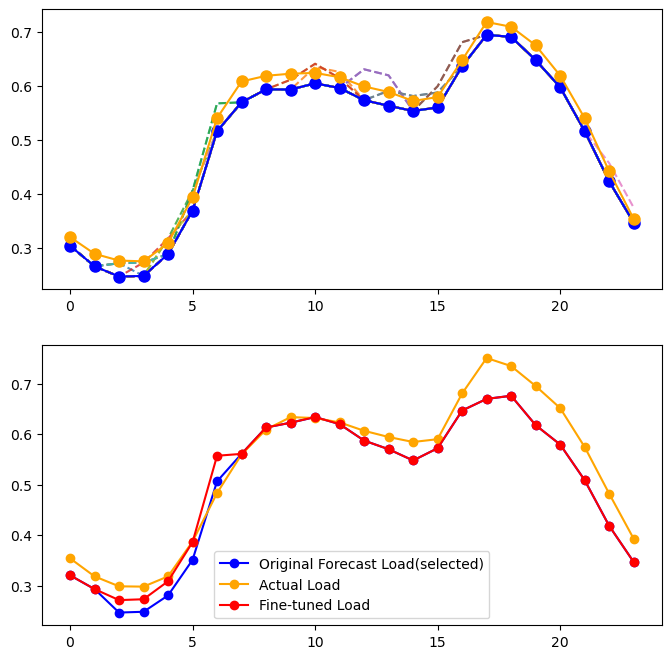

Original cost: 3221.8686674804685, Fine-tuned cost: 3154.9359164171515
3212.00385067636
3151.006299104427


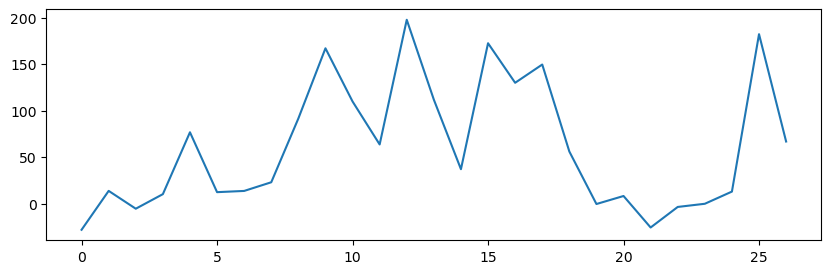

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [23]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 28/29
Found 3 similar days for inquiry 27
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2543.20, original cost 2547.99, (reduction 4.79)
Discovered valid strategy strategy_2, cost 2539.81, original cost 2547.99, (reduction 8.18)
Discovered valid strategy strategy_5, cost 2539.39, original cost 2547.99, (reduction 8.60)
Discovered valid strategy strategy_6, cost 2541.83, original cost 2547.99, (reduction 6.16)
Discovered valid strategy strategy_10, cost 2541.68, original cost 2547.99, (reduction 6.31)
Strategy generation attempt #2 (Current valid strategies: 5/20)
Discovered valid strategy strategy_1, cost 2543.20, origin

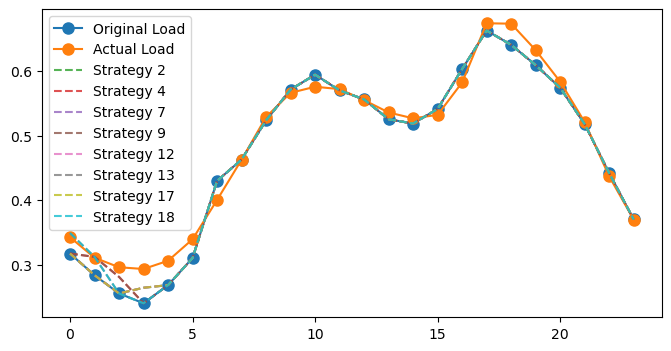

Found 1 relevant failed reflection cases for inquiry 27


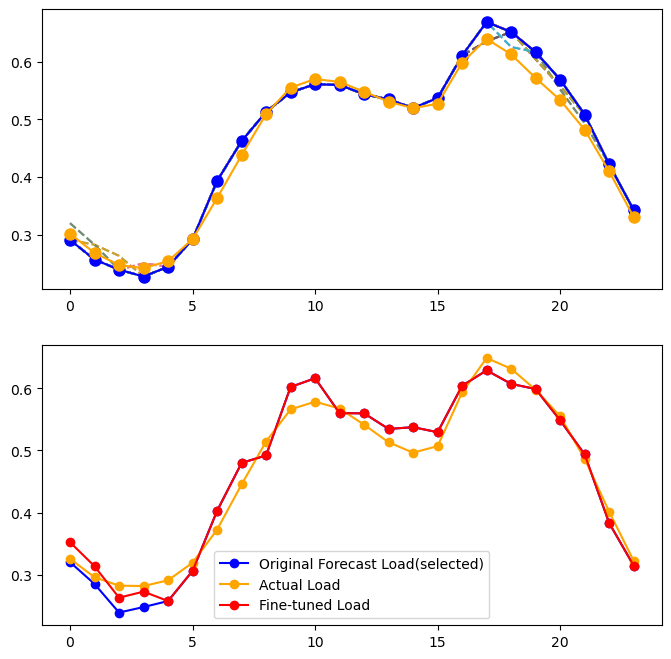

Original cost: 2680.726507324219, Fine-tuned cost: 2645.889989292323
3193.0296598423547
3132.9664308968518


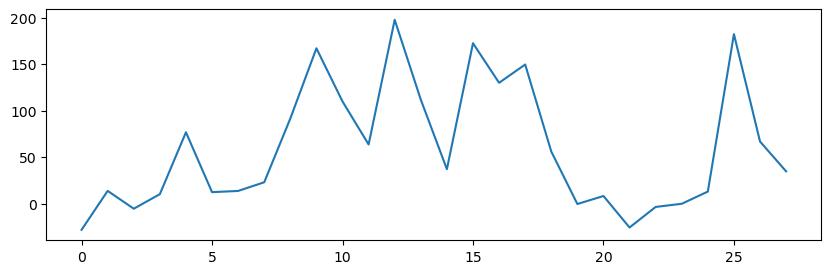

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [23]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 29/29
Found 3 similar days for inquiry 28
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 2466.67, original cost 2473.13, (reduction 6.46)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Discovered valid strategy strategy_2, cost 2466.67, original cost 2473.13, (reduction 6.46)
Discovered valid strategy strategy_6, cost 2463.71, original cost 2473.13, (reduction 9.43)
Strategy generation attempt #3 (Current valid strategies: 3/20)
Providing actual load values
Discovered valid strategy strategy_2, cost 2466.67, original cost 2473.13, (reduction 6.46)
Strategy generation attempt #4 (Current valid strategies: 

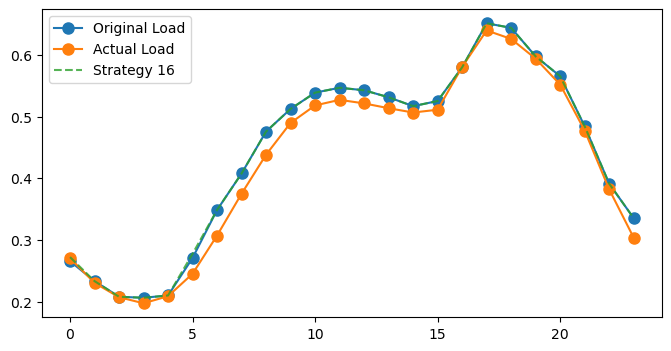

Found 1 relevant failed reflection cases for inquiry 28


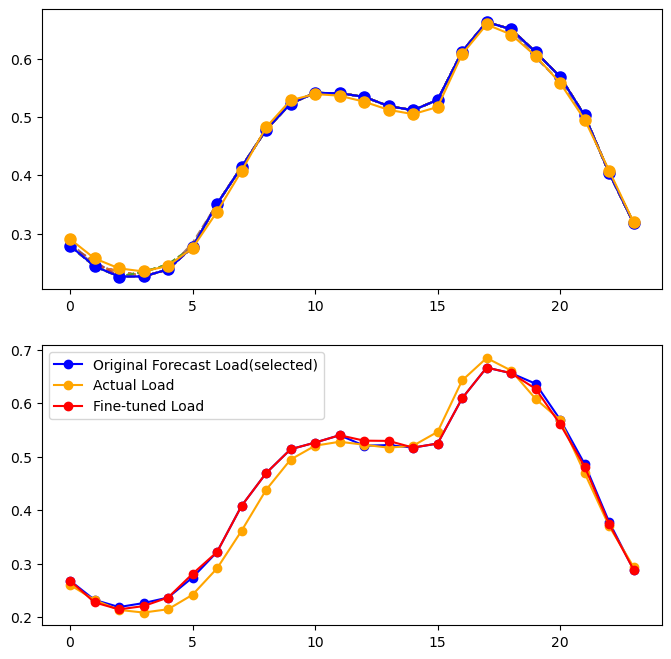

Original cost: 2503.5631875000004, Fine-tuned cost: 2509.2518873684917
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_2, cost 2501.74, original cost 2503.56, (reduction 1.82)
Discovered valid strategy strategy_4, cost 2501.55, original cost 2503.56, (reduction 2.02)
Discovered valid strategy strategy_8, cost 2501.32, original cost 2503.56, (reduction 2.25)
Strategy generation attempt #2 (Current valid strategies: 3/5)
Providing actual load values
Discovered valid strategy strategy_2, cost 2501.62, original cost 2503.56, (reduction 1.94)
Discovered valid strategy strategy_5, cost 2483.81, original cost 2503.56, (reduction 19.75)
3169.2549538995145
3111.4590328441495


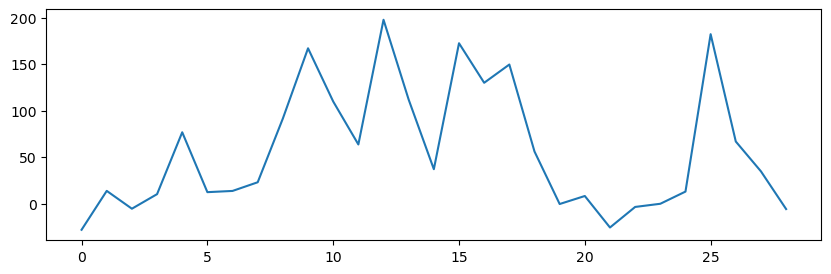

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: [23]
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []


In [ ]:
fine_tuned_result_given_by_LLM = {
    'selected_flag': [], 'original_load': [], 'optnet_load': [], 'fine_tuned_load': [], 
    'cost_org': [], 'cost_optnet': [], 'cost_after': [], 'actual_load': [],
    'few_shot_curves': [], 'few_shot_costs': [], 'few_shot_code': [], 
    'similar_load': [], 'similar_actual_load': [], 'strategy_code': []
}

skip_samples = []
validate_failures = []
reflection_records = []

for inqure_id in range(len(forecasts_load_test_insert)):
    print(f"Processing inquiry {inqure_id+1}/{len(forecasts_load_test_insert)}")
    data_for_inqure = {
        'load': forecasts_load_test_insert[inqure_id],
    }

    similar_days = db_train.get_top_k_unique_loads(data_for_inqure['load'], k=3, q=1)[0:3]
    average_similar_load_org = np.mean([day['load'] for day in similar_days], axis=0)
    average_similar_load_actual = np.mean([day['actual_load'] for day in similar_days], axis=0)
    average_similar_load_org_numpy = train_load_data.scaler_y.inverse_transform(np.array(average_similar_load_org).reshape(1,-1))[0]
    average_similar_load_actual_numpy = train_load_data.scaler_y.inverse_transform(np.array(average_similar_load_actual).reshape(1,-1))[0]
    _, _, obj_org_similar_days = optimization_module.forward(average_similar_load_org_numpy, average_similar_load_actual_numpy)
    obj_org_similar_days = obj_org_similar_days.item()

    selected_flag = 'org'
    load_nor = data_for_inqure['load']
    average_similar_load = average_similar_load_org
    actual_load_numpy = train_load_data.scaler_y.inverse_transform(np.array(actual_load_test_insert[inqure_id]).reshape(1,-1))[0]
    load_numpy_org = train_load_data.scaler_y.inverse_transform(np.array(data_for_inqure['load']).reshape(1,-1))[0]
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    higher_flag = "higher" if sum(np.array(average_similar_load) - np.array(average_similar_load_actual)) > 0 else "lower"
    reduce_flag = "reduce" if higher_flag == "higher" else "increase"
    print(f"Found {len(similar_days)} similar days for inquiry {inqure_id}")
    
    system_prompt = generate_prompt_sys(args, data_for_inqure)

    full_user_prompt = f"SYSTEM INSTRUCTIONS:\n{system_prompt}."
    full_user_prompt += f"""\n\nHint: You have two approaches to reduce cost:  

    1. Compare the actual value and forecast of the similar day, try to learn some error reduction strategies. In historical similar days, we found the forecasts were {higher_flag} than actual, so you can try to {reduce_flag} the load in some hours to reduce cost.  
    2. Compare the future positive and negative reserve prices.  
    - If the positive reserve price is much higher than the negative reserve price, you should schedule more generation in the day-ahead market.  
    - If the negative reserve price is higher, schedule less generation to reduce potential costs.  
    """

    # Few-shot code integration
    print("Generating few-shot prompts based on similar days...")
    strategy_history, valid_strategies = few_shot_prompt_generate(args, similar_days, max_strategies=20, max_attempts=6)
    
    # Validate strategies on validation set
    selected_strategy = []
    similar_days_val = db_val.get_top_k_unique_loads(data_for_inqure['load'], k=3, q=1)[0:3]
    average_similar_load_val = np.mean([day['load'] for day in similar_days_val], axis=0)
    average_similar_load_actual_val = np.mean([day['actual_load'] for day in similar_days_val], axis=0)
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(average_similar_load_val)), average_similar_load_val, markersize=8, marker='o', label='Original Load')
    plt.plot(range(len(average_similar_load_val)), average_similar_load_actual_val, markersize=8, marker='o', label='Actual Load')
    
    load_nor_val = average_similar_load_val.tolist()
    load_val_numpy = train_load_data.scaler_y.inverse_transform(np.array(load_nor_val).reshape(1,-1))[0]
    actual_load_val_numpy = train_load_data.scaler_y.inverse_transform(np.array(average_similar_load_actual_val).reshape(1,-1))[0]

    for strategy in valid_strategies:
        strategy_result = evaluate_individual_strategies(
            strategy['code'],
            load_nor_val,
            max_change_percent=0.1
        )
        selected_curve_val = strategy_result[list(strategy_result.keys())[0]]['adjusted_curve']

        fine_tune_load_val_numpy = train_load_data.scaler_y.inverse_transform(np.array(selected_curve_val).reshape(1,-1))[0]
        _, _, obj_org_val = optimization_module.forward(load_val_numpy, actual_load_val_numpy)
        _, _, obj_fine_tune_val = optimization_module.forward(fine_tune_load_val_numpy, actual_load_val_numpy)

        if obj_org_val > obj_fine_tune_val:
            selected_strategy.append(strategy)
            plt.plot(range(24), selected_curve_val, label=strategy['name'], linestyle='--', alpha=0.8)
            print(f"Strategy {strategy['name']} succeeded on validation set, cost {obj_fine_tune_val.item():.2f}, original cost {obj_org_val.item():.2f}, (reduction {obj_org_val.item()-obj_fine_tune_val.item():.2f})")
        else:
            print(f"Strategy {strategy['name']} failed on validation set, cost {obj_fine_tune_val.item():.2f}, original cost {obj_org_val.item():.2f}, (increase {obj_org_val.item()-obj_fine_tune_val.item():.2f})")
    plt.legend()
    plt.show()

    # Skip if no valid fine-tuning strategies found
    if len(selected_strategy) == 0:
        print(f"Inquiry {inqure_id}: No valid strategy found, using original curve as fine-tuned result.")
        _, _, obj_org = optimization_module.forward(load_numpy_org, actual_load_numpy)

        fine_tuned_result_given_by_LLM['fine_tuned_load'].append(data_for_inqure['load'])
        fine_tuned_result_given_by_LLM['cost_after'].append(obj_org.item())

        fine_tuned_result_given_by_LLM['selected_flag'].append(selected_flag)
        fine_tuned_result_given_by_LLM['actual_load'].append(actual_load_test_insert[inqure_id])
        fine_tuned_result_given_by_LLM['original_load'].append(data_for_inqure['load'])
        fine_tuned_result_given_by_LLM['similar_load'].append(average_similar_load.tolist())
        fine_tuned_result_given_by_LLM['similar_actual_load'].append(average_similar_load_actual.tolist())
        fine_tuned_result_given_by_LLM['cost_org'].append(obj_org.item())
        fine_tuned_result_given_by_LLM['few_shot_costs'].append([])
        fine_tuned_result_given_by_LLM['few_shot_curves'].append([])
        fine_tuned_result_given_by_LLM['few_shot_code'].append([])
        fine_tuned_result_given_by_LLM['strategy_code'].append('')
        skip_samples.append(inqure_id)
        # Visualization
        if len(fine_tuned_result_given_by_LLM['cost_org']) > 1:
            print(np.mean(fine_tuned_result_given_by_LLM['cost_org']))
            print(np.mean(fine_tuned_result_given_by_LLM['cost_after']))
            plt.figure(figsize=(8, 3))
            plt.plot(
                range(len(fine_tuned_result_given_by_LLM['cost_org'])),
                np.array(fine_tuned_result_given_by_LLM['cost_org']) - np.array(fine_tuned_result_given_by_LLM['cost_after']),
                label='Compared to original'
            )
            plt.show()
            plt.close()
        continue

    # Build few-shot LLM prompt
    few_shot_costs = [s['final_cost'] for s in selected_strategy]
    few_shot_curves = [s['adjusted_curve'] for s in selected_strategy]
    few_shot_codes = [s['code'] for s in selected_strategy]
    history_snippet_prompt = 'Here are some previously discovered effective adjustment strategies:\n'
    for i, s in enumerate(selected_strategy):
        history_snippet_prompt += f"Good strategy {i+1} from few-shot:\n{s['code']}\n\n"
    history_snippet_prompt += f"You should ensemble these strategies as you can only output one adjustment_strategy function.\n"

    last_fail_reflections = get_fail_reflections_by_curve_distance(reflection_records, data_for_inqure['load'], max_num=1)
    print(f"Found {len(last_fail_reflections)} relevant failed reflection cases for inquiry {inqure_id}")
    fail_reflections_prompt = ""
    if last_fail_reflections:
        fail_reflections_prompt = 'You have failed in these examples and led to cost increase, avoid these patterns:\n'
        fail_reflections_prompt += "\n### Previous failed adjustment text (avoid these patterns):\n"
        for idx, record in enumerate(last_fail_reflections):
            fail_reflections_prompt += (
                f"Fail Case {idx + 1}:\n"
                f"- Last failed strategy:\n{remove_comments(record['strategy_code'])}\n\n"
                f"- Successful strategy:\n{(record['reflection_strategy'])}\n\n"
            )

    if args.LLM_type == 'Qwen':
        response = Generation.call(
            model="qwen-plus",
            messages=[
                {"role": "user", "content": output_require_prompt},
                {"role": "assistant", "content": history_snippet_prompt},
                {"role": "assistant", "content": fail_reflections_prompt},
            ],
            parameters={
                "temperature": 0.1,
                "result_format": "text",
                "max_tokens": 2048,
                "top_k": 10
            }
        )
        raw_text = response.output.text.strip()
        func_code = extract_pure_code(raw_text)
      
    elif args.LLM_type == 'Deepseek':
        client = OpenAI(api_key=DEEPSEEK_API_KEY,
                base_url="https://api.deepseek.com")
        response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "user", "content": output_require_prompt},
            {"role": "assistant", "content": history_snippet_prompt},
            {"role": "assistant", "content": fail_reflections_prompt},
        ],
        temperature=0.1,
        max_tokens=2048,
        stream=False,
        )
        raw_text = response.choices[0].message.content.strip()
        func_code = extract_pure_code(raw_text)
        
    if selected_flag == 'org':
        selected_curve, delta_curve, strategy_code = execute_strategy_function(
            func_code,
            data_for_inqure['load'],
            max_change_percent=0.1
        )
    else:
        selected_curve, delta_curve, strategy_code = execute_strategy_function(
            func_code,
            data_for_inqure['fine_tuned_load'],
            max_change_percent=0.1
        )

    fine_tune_load_numpy =  train_load_data.scaler_y.inverse_transform(np.array(selected_curve).reshape(1, -1))[0]
    _, _, obj_org = optimization_module.forward(load_numpy_org, actual_load_numpy)
    _, _, obj_fine_tune = optimization_module.forward(fine_tune_load_numpy, actual_load_numpy)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    for i in valid_strategies:
        plt.plot(i['adjusted_curve'], label=i['name'], linestyle='--', alpha=0.8)
    if selected_flag == 'org':
        plt.plot(range(24), i['original_load'], markersize=8, marker='o', label='Original Load', color='blue')
    else:
        plt.plot(range(24), i['original_load'], markersize=8, marker='o', label='Optnet Load', color='green')
    plt.plot(range(24), i['actual_load'], markersize=8, marker='o', label='Actual Load', color='orange')
    # plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(range(24), data_for_inqure['load'], label='Original Forecast Load(selected)', marker='o', color='blue')
    plt.plot(range(24), actual_load_test_insert[inqure_id], label='Actual Load', marker='o', color='orange')
    plt.plot(range(24), selected_curve, label='Fine-tuned Load', marker='o', color='red')
    plt.legend()
    plt.show()
    print(f"Original cost: {obj_org.item()}, Fine-tuned cost: {obj_fine_tune.item()}")

    if selected_flag == 'org' and obj_fine_tune.item() < obj_org.item():
            reflection_strategy = "Cost reduction achieved."
            insight = f"Successfully reduced cost by {obj_org.item() - obj_fine_tune.item():.2f}."
    elif selected_flag == 'org' and obj_fine_tune.item() > obj_org.item():
        failures = [{
            "inqure_id": inqure_id,
            "load": data_for_inqure['load'],
            "actual_load": actual_load_test_insert[inqure_id],
            'fine_tuned_load': selected_curve,
            "cost_before": obj_org.item(),
            "cost_after": obj_fine_tune.item(),
            "strategy_code": strategy_code,
        }]

        reflection_strategy_history, reflection_valid_strategies = few_shot_prompt_generate(args, failures, max_strategies=5, max_attempts=3,failure_strategy=strategy_code)
        reflection_strategy = f"For this failure case, consider:"
        for i in range(len(reflection_valid_strategies)):
            strategy = reflection_valid_strategies[i]
            reflection_strategy += f"Successful strategy {i} for failure case:\n{remove_comments(strategy['code'])}\n"

    reflection_records.append({
        "inquiry_id": inqure_id,
        "original_load": data_for_inqure['load'],
        "actual_load": actual_load_test_insert[inqure_id],
        "fine_tuned_load": selected_curve,
        "cost_before": obj_org.item(),
        "cost_after": obj_fine_tune.item(),
        "strategy_code": strategy_code,
        "reflection_strategy": reflection_strategy,
        "similar_day_comparison": f"Similar days showed forecast was {higher_flag} than actual"
    })
    reflection_records = reflection_records[-10:]  # Keep only last 10 records

    fine_tuned_result_given_by_LLM['selected_flag'].append(selected_flag)
    fine_tuned_result_given_by_LLM['actual_load'].append(actual_load_test_insert[inqure_id])
    fine_tuned_result_given_by_LLM['original_load'].append(data_for_inqure['load'])
    fine_tuned_result_given_by_LLM['fine_tuned_load'].append(selected_curve)
    fine_tuned_result_given_by_LLM['cost_after'].append(obj_fine_tune.item())
    fine_tuned_result_given_by_LLM['cost_org'].append(obj_org.item())
    fine_tuned_result_given_by_LLM['similar_load'].append(average_similar_load.tolist())
    fine_tuned_result_given_by_LLM['similar_actual_load'].append(average_similar_load_actual.tolist())
    fine_tuned_result_given_by_LLM['few_shot_costs'].append(few_shot_costs)
    fine_tuned_result_given_by_LLM['few_shot_curves'].append(few_shot_curves)
    fine_tuned_result_given_by_LLM['few_shot_code'].append(few_shot_codes)
    fine_tuned_result_given_by_LLM['strategy_code'].append(strategy_code)

    if len(fine_tuned_result_given_by_LLM['cost_org']) > 1:
        print(np.mean(fine_tuned_result_given_by_LLM['cost_org']))
        print(np.mean(fine_tuned_result_given_by_LLM['cost_after']))
        plt.figure(figsize=(10, 3))
        plt.plot(
            range(len(fine_tuned_result_given_by_LLM['cost_org'])),
            np.array(fine_tuned_result_given_by_LLM['cost_org']) - np.array(fine_tuned_result_given_by_LLM['cost_after']),
            label='Compared to original'
        )
        plt.show()
        plt.close()

    print(f"The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: {skip_samples}")
    print(f"The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: {validate_failures}")

    with open('../Result/Tree+LP/'+args.LLM_type+'.pkl', 'wb') as f:
        pickle.dump(fine_tuned_result_given_by_LLM, f)

### result

In [42]:

print(np.mean(cost_list_ideal))
print(np.mean(fine_tuned_result_given_by_LLM['cost_org']))
print(np.mean(fine_tuned_result_given_by_LLM['cost_after']))

2523.7132413793106
3169.2549538995145
3111.4590328441495
